In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
# from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from cmcrameri import cm
from PIL import Image

import corner

from landscapes.module_helper_functions import modules_from_txt
from landscapes.landscapes import CellDiff_Dataset_Landscape
from landscapes.landscape_visuals import visualize_all

plt.rcParams.update({'figure.dpi': 100})  # Change to 200 for high res figures
plt.rcParams.update({'font.size': 15})  

%load_ext autoreload

In [2]:

# optimization_log 100_is the first 100 simulations of optimization_log

# data_dir = '../alfyn_results/saved_files/CellDiff_Dataset_Landscape/'
# file_name = data_dir + 'optimization_log_100.csv'
# 
# log = pd.read_csv(file_name, sep='\t', names=['Timecode', 'Init timecode', 'Fitness'], skiprows=1)
# print(log.head(5))
# print(log.shape)
# print(np.sum(log['Fitness']>-0.2))

# data_dir = '../alfyn_results_new/saved_files/CellDiff_Dataset_Landscape/'
data_dir = '../alfyn_results_wide_prior/saved_files_2/CellDiff_Dataset_Landscape/'

file_name = data_dir + 'optimization_log.csv'

log = pd.read_csv(file_name, sep='\t', names=['Timecode', 'Init timecode', 'Fitness'], skiprows=1)
print(log.head(5))
print(log.shape)
# log = log[-200:]
print(np.sum(log['Fitness']>-0.2))


#  _____________ Concatenate another log _____________
#   saved files 1 (2024-08-14) is 200 simulations with wide prior for a 
# 
# data_dir = '../alfyn_results_new/saved_files_1/CellDiff_Dataset_Landscape/'
# file_name = data_dir + 'optimization_log.csv'
# 
# log1 = pd.read_csv(file_name, sep='\t', names=['Timecode', 'Init timecode', 'Fitness'], skiprows=1)
# print(log1.head(5))
# print(log1.shape)
# print(np.sum(log1['Fitness']>-0.2))
# 
# log = pd.concat([log, log1], axis=0, ignore_index=False, keys=[0,1])
# print(log.index)
# print(log.shape)
# print(np.sum(log['Fitness']>-0.2))
# 
# data_dirs = ('../alfyn_results_new/saved_files/CellDiff_Dataset_Landscape/', '../alfyn_results_new/saved_files_1/CellDiff_Dataset_Landscape/')


          Timecode    Init timecode   Fitness
0  20240903-150036  20240903-150005 -0.250266
1  20240903-150758  20240903-150726 -0.178698
2  20240903-151500  20240903-151429 -0.310197
3  20240903-152229  20240903-152157 -0.218244
4  20240903-152955  20240903-152924 -0.199684
(1200, 3)
270


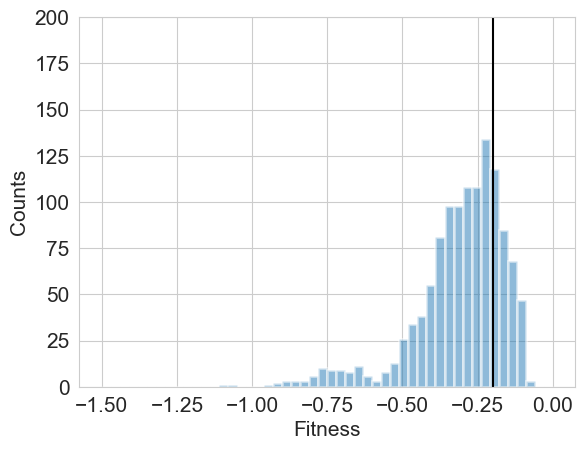

/var/folders/yn/r99j3qy962lg5cwmzc1dpqg40000gn/T/ipykernel_26096/4071150860.py:23: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  all_fitness[i] = log.loc[log['Timecode']==timecode, 'Fitness']


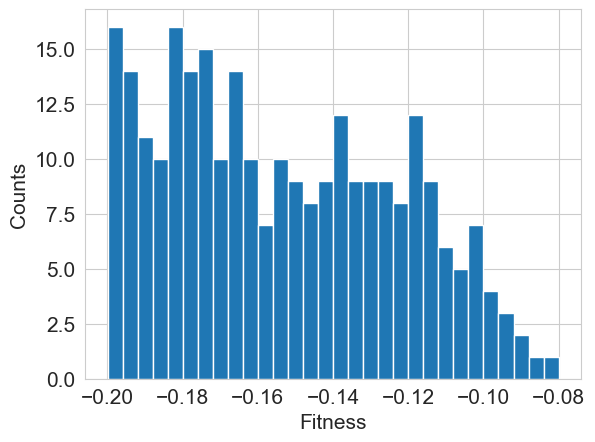

In [3]:
bins = np.linspace(-1.5, 0, 51)

plt.hist(log['Fitness'], bins=bins, density=False, alpha=0.5, histtype='bar', lw=2, label='All')
# plt.hist(log[:-600]['Fitness'], bins=bins, density=False, alpha=0.8, histtype='bar', label='N = 50')
# plt.hist(log[-600:-400]['Fitness'], bins=50, density=False, alpha=0.4, histtype='bar', label='N = 100')
# plt.hist(log[-400:]['Fitness'], bins=bins, density=False, alpha=0.9, histtype='bar', label='N = 200')

# plt.legend()

# plt.hist(log[-200:]['Fitness'], bins=50, density=True, alpha=0.5)
plt.vlines(-0.2, 0, 200, color='k')
plt.xlabel('Fitness')
plt.ylabel('Counts')
plt.ylim((0, 200))
plt.show()

fitness_threshold = -0.2   #### ______________
gen = 299
n_landscapes = len(log['Timecode'][log['Fitness'] > fitness_threshold])
all_fitness = np.zeros(n_landscapes)

for i, timecode in enumerate(log['Timecode'][log['Fitness'] > fitness_threshold]):
    all_fitness[i] = log.loc[log['Timecode']==timecode, 'Fitness']
    
timecodes = log['Timecode'][log['Fitness'] > fitness_threshold]
len(timecodes)

plt.hist(all_fitness, bins=30)
plt.xlabel('Fitness')
plt.ylabel('Counts')
plt.show()

In [4]:
def figure_from_timecode(timecode, name='landscape_1', data_dir=data_dir):
    filename = data_dir + timecode + '/result_' + name + '.png'
    image = Image.open(filename)
    display(image)

0 - red, 1 - orange, 2 - yellow, 3 - green, 4 - blue 
Pairwise distances: 01, 02, 03, 04, 12, 13, 14, 23, 24, 34 
Module parameters x5 : a (x3), s (x3)
->  40 parameters 

0 1 0.7185626300030602
0 2 0.08812935404160109
0 3 0.22223133513897939
0 4 0.5916909325978217
1 2 0.6892751992040985
1 3 0.5298482348809586
1 4 0.552889500189821
2 3 0.2448208818585071
2 4 0.63525957761918
3 4 0.3943236170925545


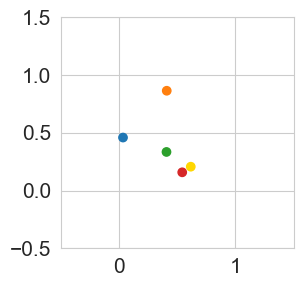

0 1 0.7185626300030602
0 2 0.08812935404160109
0 3 0.22223133513897939
0 4 0.5916909325978217
1 2 0.6892751992040984
1 3 0.5298482348809586
1 4 0.552889500189821
2 3 0.2448208818585071
2 4 0.63525957761918
3 4 0.3943236170925544


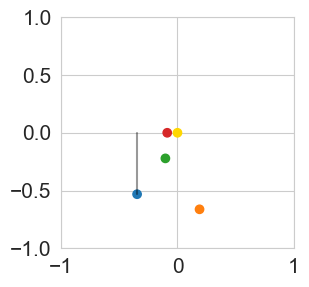

In [5]:
def transform_coords(old_coords, origin=0, direction=2, left=None, bottom=None):
    coords = old_coords - old_coords[origin]   # move origin to module 0
    d = np.linalg.norm(coords[direction])  # distance to module 1
    x, y = coords[direction, 0], coords[direction, 1]
    R = np.array([[x, y], [-y, x]])/d
    coords = (R @ coords.T).T
    if bottom is not None:
        if coords[bottom, 1] > 0:    # the last module is below 0 
            coords[:, 1] *= -1.
    if left is not None:
        if coords[left, 0] > 0:
            coords[:, 0] *= -1.
    return coords

plt.figure(figsize=(3,3))
n_points = 5
colors = ('tab:red', 'tab:orange', 'gold', 'tab:green', 'tab:blue')
coords = np.random.random((n_points, 2))
for i in range(n_points):
    for j in range(i+1, n_points):
         print(i, j, np.linalg.norm(coords[i]-coords[j]))
plt.scatter(coords[:,0], coords[:,1], c=colors)
plt.xlim((-0.5,1.5))
plt.ylim((-0.5, 1.5))

plt.show()

coords = transform_coords(coords, origin=2, direction=0, left=0, bottom=-1)

plt.figure(figsize=(3,3))
# plt.plot((0, 5), (0, 0), c='k', alpha=0.4)
plt.plot((coords[-1, 0], coords[-1, 0]), (0, coords[-1, 1]), c='k', alpha=0.4)

for i in range(n_points):
    for j in range(i+1, n_points):
         print(i, j, np.linalg.norm(coords[i]-coords[j]))
plt.scatter(coords[:,0], coords[:,1], c=colors)
plt.xlim((-1,1))
plt.ylim((-1,1))
plt.show()


In [71]:
# fitness_threshold = -0.15  #  best landscapes
# gen = 300
# n_landscapes = len(log['Timecode'][log['Fitness'] > fitness_threshold])
# all_fitness = np.zeros((n_landscapes))
# 
# timecodes = log['Timecode'][log['Fitness'] > fitness_threshold]
# # index = log.index[log['Fitness'] > fitness_threshold]
# len(timecodes)
# 
# for i in range(n_landscapes):
#     timecode = timecodes.iloc[i]
#     # data_dir = data_dirs[index[i][0]]
#     # figure_from_timecode(timecode, 'landscape_1', data_dir)
#     figure_from_timecode(timecode, 'landscape_2', data_dir)
#     figure_from_timecode(timecode, 'cell_trajectories_1', data_dir)
#     # figure_from_timecode(timecode, 'cell_trajectories_2', data_dir)
#     figure_from_timecode(timecode, 'proportions_0', data_dir)
#     # figure_from_timecode(timecode, 'fitness_traj', data_dir)
#     
#     

In [72]:
%autoreload

# data_dir = data_dirs[1]
timecode = log.iloc[-1]['Timecode']
filename = data_dir + timecode + '/' + timecode + '_module_list_' + str(300) + '.txt'
with open(filename, 'r') as f:
    module_list = modules_from_txt(filename) 

n_modules = len(module_list)

# n_pars = n_modules * (n_modules-1) // 2 + n_modules * (len(module_list[0].a) + len(module_list[0].s))
# n_pars = n_modules * (n_modules-1) // 2 + n_modules * (len(module_list[0].a) -1 + len(module_list[0].s) - 1)
n_pars = (n_modules-1) * 2 - 1 + n_modules * ( len(module_list[0].a) -1 + len(module_list[0].s) - 1)
print(len(module_list[0].a), len(module_list[0].s))
# n_pars = (n_modules-1) * 2 - 1 + n_modules * ( len(module_list[0].a) -1 )
# n_pars = n_modules * (n_modules-1) // 2   ##

print(n_landscapes, n_pars)
all_pars = np.zeros((n_landscapes, n_pars))   

colors = ('indianred', 'tab:orange', 'gold', 'tab:green', 'tab:blue')
        
    
def pars_from_timecode(timecode, data_dir, gen):
    par_names = []
    par_colors = []
    filename = data_dir + timecode + '/' + timecode + '_module_list_' + str(gen) + '.txt'
    with open(filename, 'r') as f:
        module_list = modules_from_txt(filename)
    # module_list = module_list[:2]
    
    n_modules = len(module_list)
    # n_pars = n_modules * (n_modules-1) // 2 + n_modules * (len(module_list[0].a) + len(module_list[0].s))
    # print(n_pars)
    # all_pars = np.zeros(n_pars)
    
    coords = np.zeros((n_modules, 2))
    for i, module in enumerate(module_list):
        # print(module)
        coords[i] = module.x, module.y
    pars = []
    
    
    origin = 2
    direction = 0
    coords = transform_coords(coords, origin=origin, direction=direction, left=0, bottom=4)     ###
    for i in range(0, n_modules):
        if i == origin: # x=0, y=0
            continue
        par_names.append('x '+str(i))
        par_colors.append(colors[i])
        pars.append(coords[i,0])
        if i == direction:  # y = 0
            continue
        par_names.append('y '+str(i))
        pars.append(coords[i,1])
        par_colors.append(colors[i])
    
    # for i in range(n_modules):
    #     for j in range(i+1, n_modules):
    #         par_names.append('Dist '+str(i)+str(j))
    #         pars.append(np.linalg.norm(coords[i]-coords[j]))
    #      # print(i, j, np.linalg.norm(coords[i]-coords[j]))
    # 
    for i, module in enumerate(module_list):
        pars.extend(module.a[1:])
        for j in range(1, len(module.a)):
            par_names.append('M'+str(i)+' a'+ str(j))
            par_colors.append(colors[i])
            
    for i, module in enumerate(module_list):
        pars.extend(module.s[1:])
        for j in range(1, len(module.s)):
            par_names.append('M'+str(i)+' s'+ str(j))
            par_colors.append(colors[i])
    # print(par_names)
    
    return np.array(pars), par_names, par_colors


3 3
270 27


In [73]:
def landscape_from_timecode(timecode, data_dir, gen, landscape_pars):
    filename = data_dir + timecode + '/' + timecode + '_module_list_' + str(gen) + '.txt'
    with open(filename, 'r') as f:
        module_list = modules_from_txt(filename)
    landscape = CellDiff_Dataset_Landscape(module_list, A0=landscape_pars['A0'])
    return landscape

landscape_pars = {
    'A0': 0.005,
}


    # image.show()
    

In [74]:
%autoreload

fitness_threshold = -0.2  
n_landscapes = len(log['Timecode'][log['Fitness'] > fitness_threshold])
all_fitness = np.zeros((n_landscapes))


for i, timecode in enumerate(log['Timecode'][log['Fitness'] > fitness_threshold]):
    all_fitness[i] = log.loc[log['Timecode']==timecode, 'Fitness']
    

/var/folders/yn/r99j3qy962lg5cwmzc1dpqg40000gn/T/ipykernel_26096/659869355.py:9: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  all_fitness[i] = log.loc[log['Timecode']==timecode, 'Fitness']


In [75]:
timecodes = log['Timecode'][log['Fitness'] > fitness_threshold]
index = log.index[log['Fitness'] > fitness_threshold]
len(timecodes)

all_pars = np.zeros((n_landscapes, n_pars))   


for i, timecode in enumerate(timecodes):
    # if index[i][0] == 0:
    #     gen = 299
    #     data_dir = data_dirs[0]
    # else:
    #     gen = 300
    #     data_dir = data_dirs[1]
        
    all_pars[i, :], par_names, par_colors = pars_from_timecode(timecode, data_dir, gen)
    

In [76]:
print(par_names)
print(par_colors)

['x 0', 'x 1', 'y 1', 'x 3', 'y 3', 'x 4', 'y 4', 'M0 a1', 'M0 a2', 'M1 a1', 'M1 a2', 'M2 a1', 'M2 a2', 'M3 a1', 'M3 a2', 'M4 a1', 'M4 a2', 'M0 s1', 'M0 s2', 'M1 s1', 'M1 s2', 'M2 s1', 'M2 s2', 'M3 s1', 'M3 s2', 'M4 s1', 'M4 s2']
['indianred', 'tab:orange', 'tab:orange', 'tab:green', 'tab:green', 'tab:blue', 'tab:blue', 'indianred', 'indianred', 'tab:orange', 'tab:orange', 'gold', 'gold', 'tab:green', 'tab:green', 'tab:blue', 'tab:blue', 'indianred', 'indianred', 'tab:orange', 'tab:orange', 'gold', 'gold', 'tab:green', 'tab:green', 'tab:blue', 'tab:blue']


In [77]:
colors

('indianred', 'tab:orange', 'gold', 'tab:green', 'tab:blue')

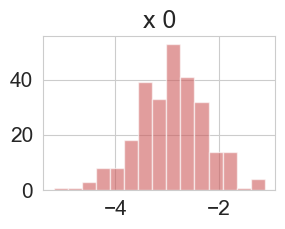

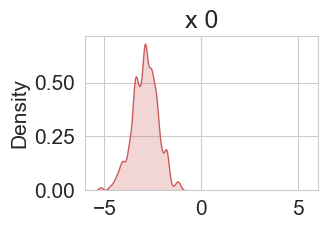

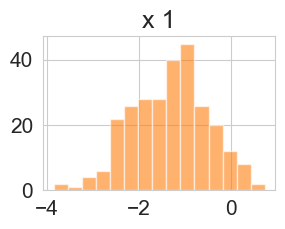

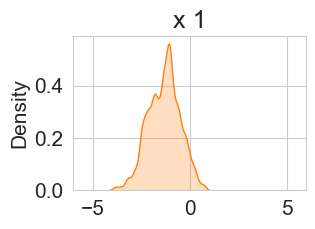

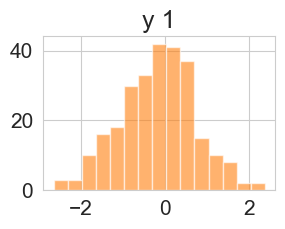

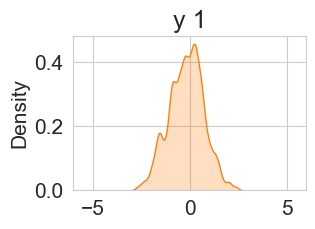

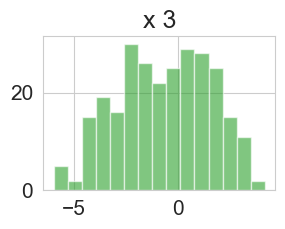

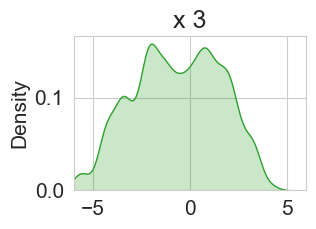

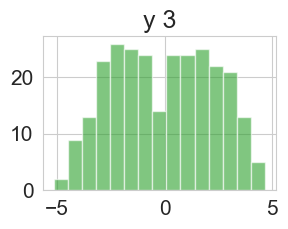

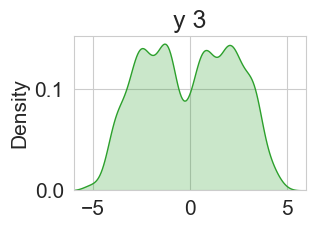

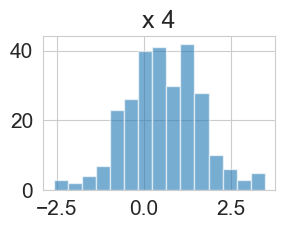

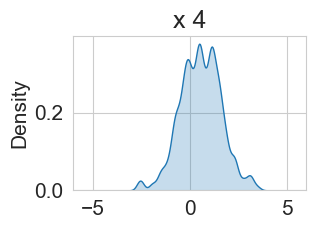

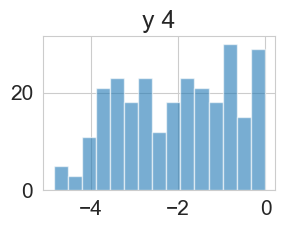

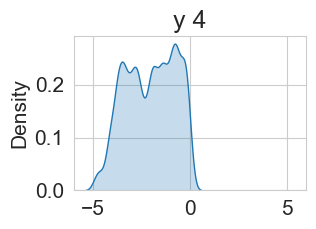

In [78]:
# all_pars

# for j in range(10):
for j in range(7):
    plt.figure(figsize=(3,2))
    plt.hist(all_pars[:, j], bins=15, alpha=0.6, color=par_colors[j])
    plt.title(par_names[j])
    plt.show()
    plt.figure(figsize=(3,2))
    sns.kdeplot(all_pars[:, j], fill=True, bw_adjust=0.5, color=par_colors[j])
    plt.title(par_names[j])
    # plt.xlim([0, 10])

    plt.xlim((-6,6))
    plt.show()

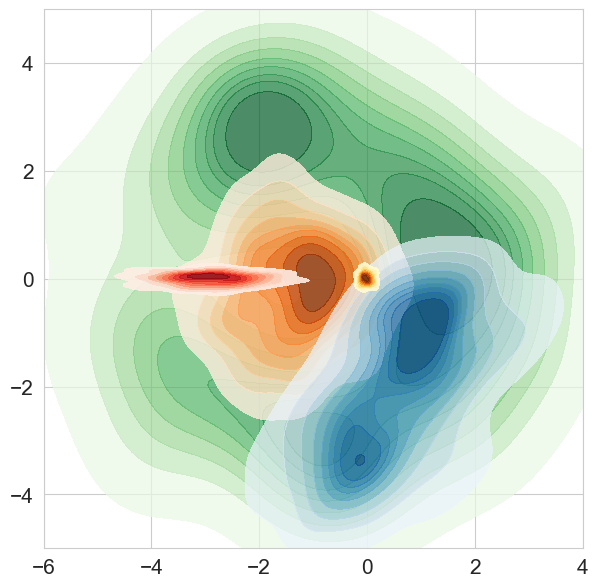

In [79]:
colors = ('tab:red', 'tab:orange', 'gold', 'tab:green', 'tab:blue')
fig, ax = plt.subplots(figsize=(7,7))
sns.kdeplot(x=all_pars[:, 3], y=all_pars[:, 4], cmap='Greens', fill=True, alpha=0.7)
sns.kdeplot(x=all_pars[:, 1], y=all_pars[:, 2], cmap='Oranges', fill=True, alpha=0.8)

sns.kdeplot(x=all_pars[:, 5], y=all_pars[:, 6], cmap='Blues', fill=True, alpha=0.7)

sns.kdeplot(x=all_pars[:, 0], y=0.1*np.random.randn(n_landscapes), cmap='Reds', fill=True, alpha=0.9)
sns.kdeplot(x=0.1*np.random.randn(n_landscapes), y=0.1*np.random.randn(n_landscapes), cmap='YlOrBr', fill=True, alpha=0.9)



for i in range(n_landscapes):
    coords = np.zeros((5, 2))
    coords[0, 0] = all_pars[i, 0]
    coords[1, :] = all_pars[i, 1:3]
    coords[3, :] = all_pars[i, 3:5]
    coords[4, :] = all_pars[i, 5:7]
    # coords[:, 0] *= -1
    # coords[:, 0] += (coords[0, 0] + coords[2,0])/2
    
    # coords[1, :] = all_pars[i, :2]
    # coords[2, 0] = all_pars[i, 2]
    # coords[3, :] = all_pars[i, 3:5]
    # coords[4, :] = all_pars[i, 5:7]
    # coords /= coords[2, 0]

# for i in range(n_landscapes):
#     plt.scatter(coords[:, 0], coords[:, 1], c=colors, alpha=0.3, edgecolors=None)

    # plt.plot(coords[0:3, 0], coords[0:3, 1], linewidth=1, alpha=0.15, c='darkorange')
    
    # plt.plot(coords[-2:, 0], coords[-2:, 1], linewidth=1, alpha=0.2, c='seagreen')
    
# for m in range(5):


plt.ylim((-5,5))
plt.xlim((-4,6))
plt.xlim((-6, 4))
# plt.ylim((-3,3))
# plt.xlim((-3,3))
ax.set_aspect('equal')
plt.show()

In [15]:
par_names[26]

'M4 s2'

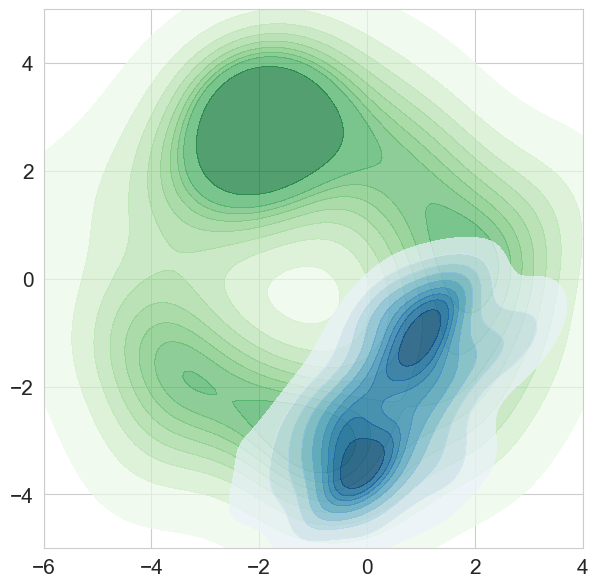

In [16]:
fig, ax = plt.subplots(figsize=(7,7))
sns.kdeplot(x=all_pars[:, 3], y=all_pars[:, 4], weights=all_pars[:, 24], cmap='Greens', fill=True, alpha=0.7)
# sns.kdeplot(x=all_pars[:, 1], y=all_pars[:, 2], cmap='Oranges', fill=True, alpha=0.8)

sns.kdeplot(x=all_pars[:, 5], y=all_pars[:, 6], cmap='Blues', weights=all_pars[:, 26], fill=True, alpha=0.7)

# sns.kdeplot(x=all_pars[:, 0], y=0.1*np.random.randn(n_landscapes), cmap='Reds', fill=True, alpha=0.9)
# sns.kdeplot(x=0.1*np.random.randn(n_landscapes), y=0.1*np.random.randn(n_landscapes), cmap='YlOrBr', fill=True, alpha=0.9)

plt.ylim((-5,5))
plt.xlim((-4,6))
plt.xlim((-6, 4))
# plt.ylim((-3,3))
# plt.xlim((-3,3))
ax.set_aspect('equal')
plt.show()

In [80]:
print(all_pars[0])

[-4.26471383 -1.07760785 -0.50278837 -1.12815407 -3.42450765  1.60563735
 -1.110159    0.08275102  8.3362341  12.8605987   3.11618437  7.43376878
  0.55297915  7.45225056 12.31565868  7.26554516 10.72066911  0.37618245
  0.29304418  0.51743994  0.18522134  1.39116586  0.64674101  0.91128526
  0.99811008  1.0938406   0.42474625]


In [81]:
def circle_plot(pars):
    circles = []
    coords = np.zeros((5, 2))
    coords[0, 0] = pars[0]
    coords[1, :] = pars[1:3]
    coords[3, :] = pars[3:5]
    coords[4, :] = pars[5:7]
    amplitude_idx = np.arange(7, 17, 2, dtype='int')  #+ int(regime)-1
    # print(amplitude_idx)
    # print(par_names[amplitude_idx])

    size_idx = np.arange(17, 27, 2, dtype='int') #+ int(regime)-1
    # print(par_names[size_idx])
    amplitudes = pars[amplitude_idx]
    sizes = pars[size_idx]
    
    fig = plt.figure(figsize=(7,7))
    ax = plt.gca()
    
    for i in range(5):
        circle = plt.Circle(coords[i], 1.18 * sizes[i], color=colors[i],
                                  fill=False, alpha=0.25 * np.sqrt(amplitudes[i]), clip_on=True, linewidth=4, linestyle='solid')
        ax.add_patch(circle)
        
    amplitudes = pars[amplitude_idx+1]
    sizes = pars[size_idx+1] 
    
    for i in range(5):
        circle = plt.Circle(coords[i], 1.18 * sizes[i], color=colors[i],
                                  fill=True, alpha=0.25 * np.sqrt(amplitudes[i]), clip_on=True, linewidth=0)
        ax.add_patch(circle)
    
    ax.set_xlim((-6,6))
    ax.set_ylim((-6,6))
    ax.axis('off')
    ax.set_aspect('equal')
    
    plt.show(fig)
    

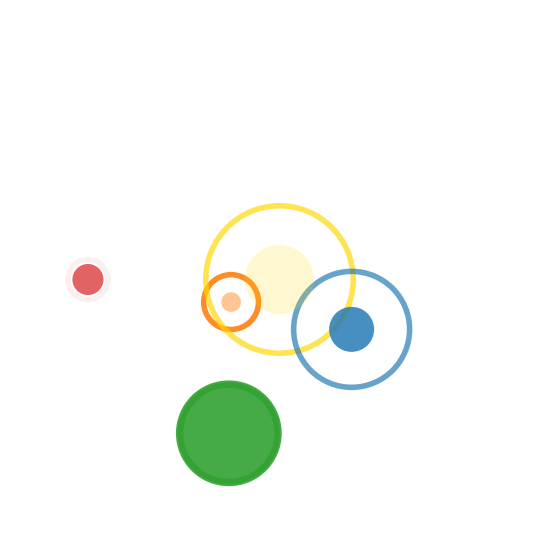

In [82]:
circle_plot(all_pars[0])

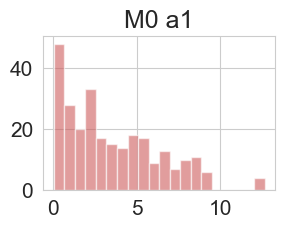

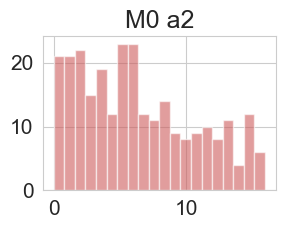

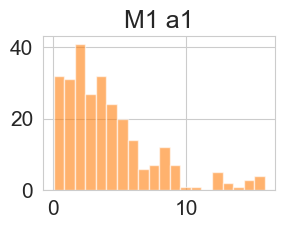

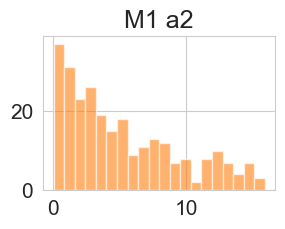

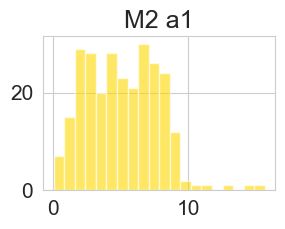

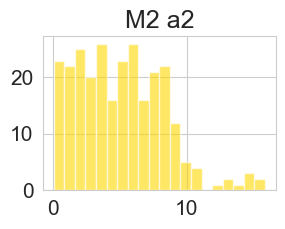

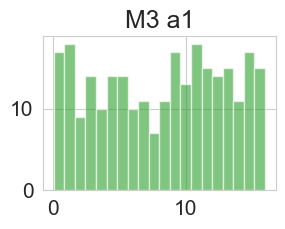

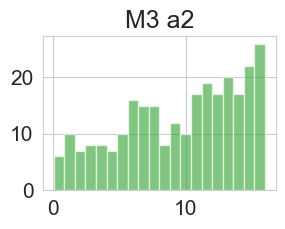

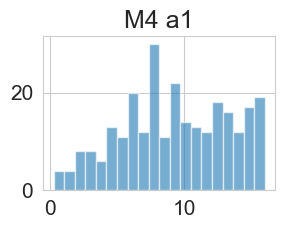

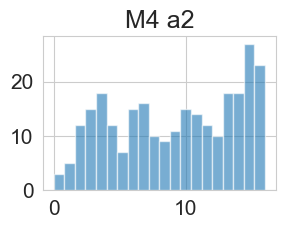

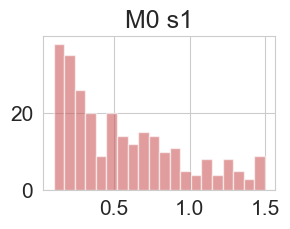

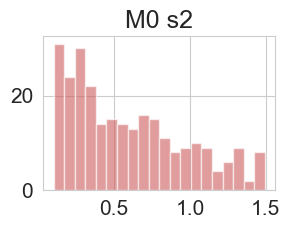

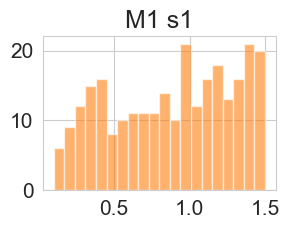

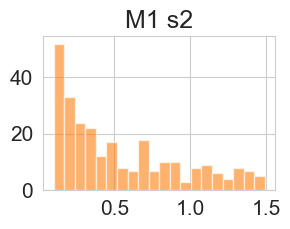

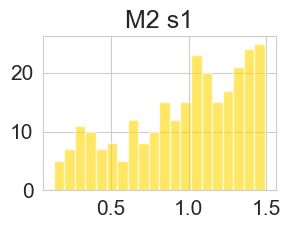

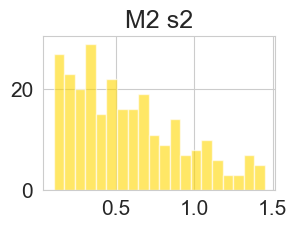

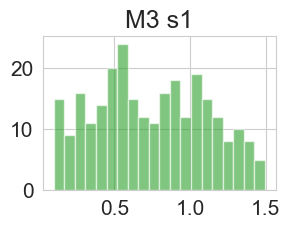

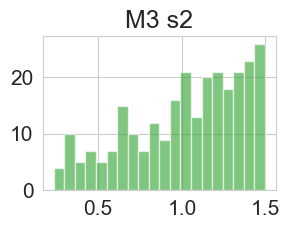

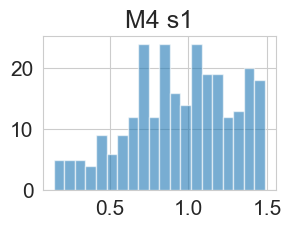

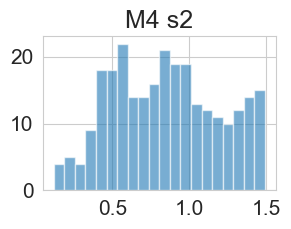

In [85]:
for j in range(7, n_pars):
    plt.figure(figsize=(3,2))
    plt.hist(all_pars[:, j], bins=20, alpha=0.6, color=par_colors[j])
    plt.title(par_names[j])
    # plt.xlim((-3,3))
    
    # plt.xlim([0, 10])
    plt.show()
    
    # plt.figure(figsize=(3,2))
    # sns.kdeplot(all_pars[:, j], fill=True, bw_adjust=0.4, color=par_colors[j], cut=0.)
    # plt.title(par_names[j])
   #### # plt.xlim([0, 10])
    # 
    # plt.xlim(left=0, right=1.5)
    # if np.max(all_pars[:, j]>2):
    #     plt.xlim(left=0, right=16)
        
    plt.show()

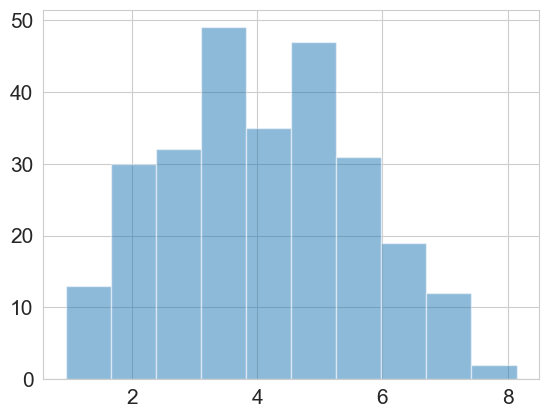

In [84]:
plt.hist(np.linalg.norm((all_pars[:, [3,5]] - all_pars[:, [4,6]]), axis = 1), alpha=0.5)
plt.show()

(270, 27)


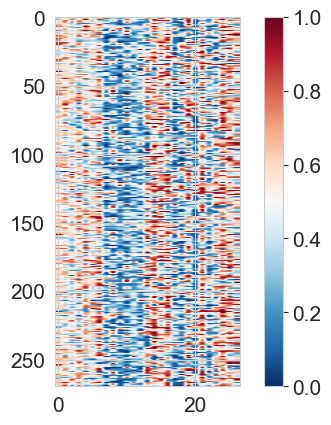

In [86]:
# scaler = StandardScaler()
scaler = MinMaxScaler()
# scaler = RobustScaler()
scaler.fit(all_pars)
# print(scaler.mean_)
scaled_pars = scaler.transform(all_pars)
print(all_pars.shape)

plt.imshow(scaled_pars, interpolation=None, cmap='RdBu_r', aspect=0.2)
plt.colorbar()
plt.show()


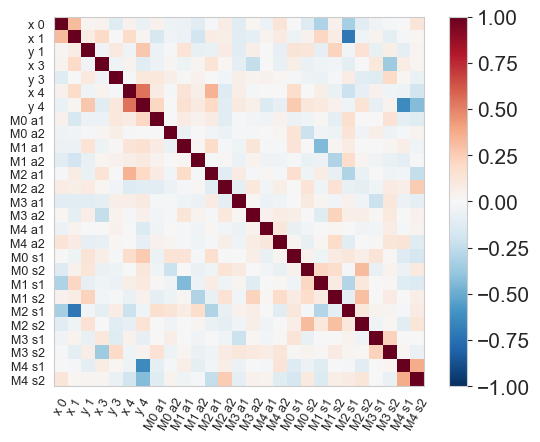

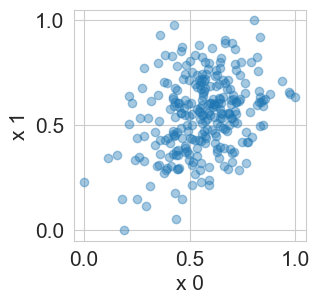

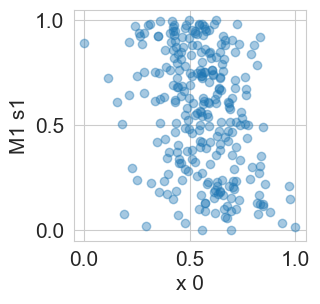

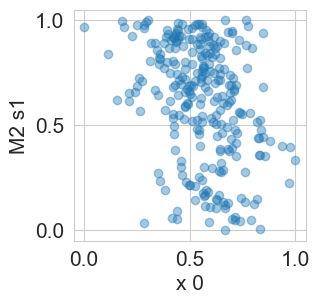

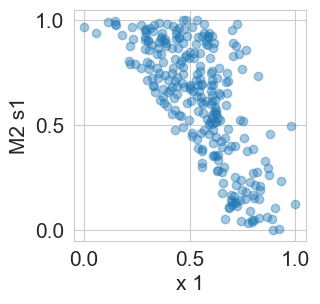

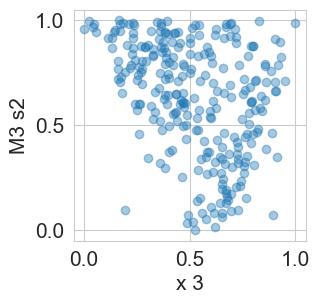

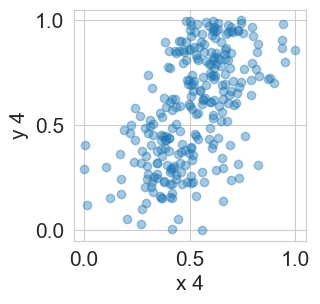

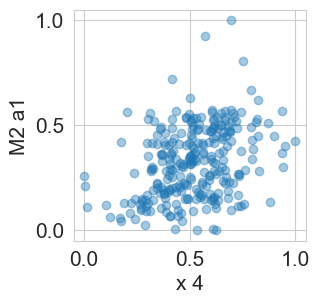

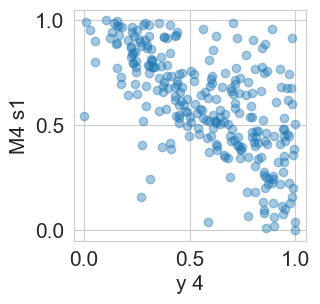

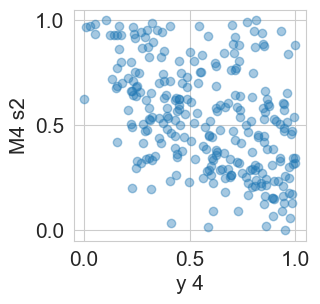

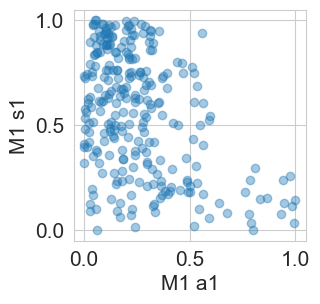

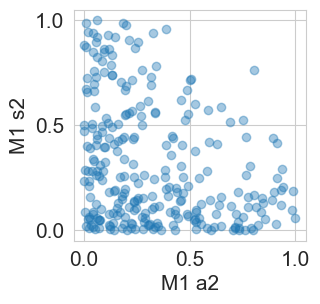

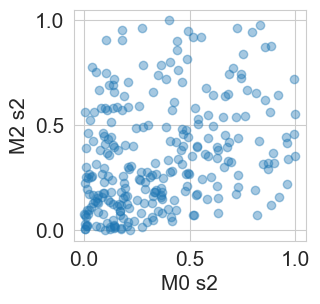

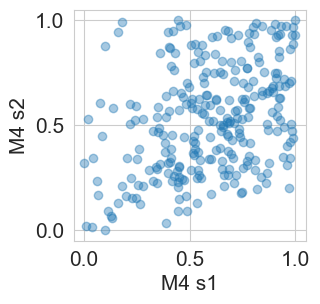

In [33]:

cov = np.corrcoef(all_pars, rowvar=False)
plt.imshow(cov, interpolation=None, cmap='RdBu_r', vmin=-1, vmax=1)
ax = plt.gca()
plt.xticks(ticks=range(n_pars), labels=par_names, size=9, rotation=60)
plt.yticks(ticks=range(n_pars), labels=par_names, size=9)
plt.colorbar()
ax.grid(False)
plt.show()


def corr_plot(par_i, par_j, pars):
    plt.figure(figsize=(3,3))
    plt.scatter(pars[:, par_i], scaled_pars[:, par_j], alpha=0.4)
    plt.xlabel(par_names[par_i])
    plt.ylabel(par_names[par_j])
    plt.yticks((0., 0.5, 1.))
    plt.xticks((0., 0.5, 1.))
    ax=plt.gca()
    # ax.grid(False)
    plt.show()


idx = np.where(np.abs(cov) > 0.3)
for i in range(len(idx[0])):
    if idx[0][i] < idx[1][i]:
        corr_plot(idx[0][i], idx[1][i], scaled_pars)
    

In [224]:
# corr_plot(3, 5, scaled_pars)
# corr_plot(4, 6, scaled_pars)
# corr_plot(4, 6, scaled_pars)
# corr_plot(3, 4, scaled_pars)
# corr_plot(5, 6, scaled_pars)

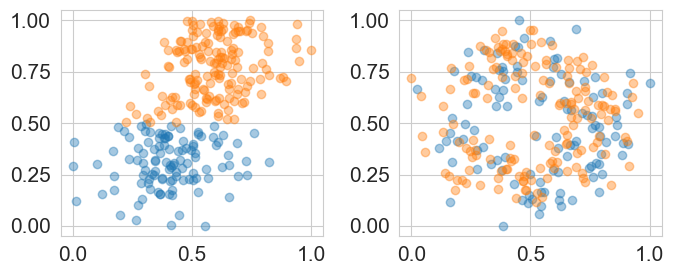

In [87]:
fig, ax = plt.subplots(1, 2, figsize=(7,3))
idx = scaled_pars[:, 6] < 0.5
ax[0].scatter(scaled_pars[idx, 5], scaled_pars[idx, 6], alpha=0.4)
ax[1].scatter(scaled_pars[idx, 3], scaled_pars[idx, 4], alpha=0.4)
idx = scaled_pars[:, 6] >= 0.5
ax[0].scatter(scaled_pars[idx, 5], scaled_pars[idx, 6], alpha=0.4)
ax[1].scatter(scaled_pars[idx, 3], scaled_pars[idx, 4], alpha=0.4)
plt.tight_layout()
plt.show()

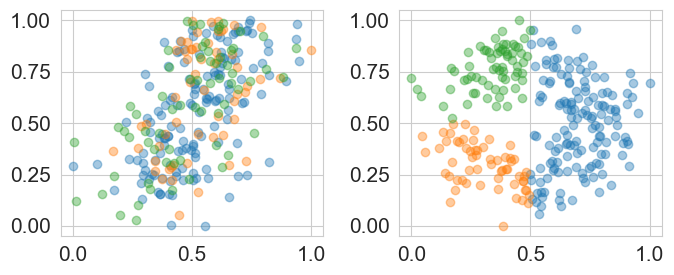

In [88]:
fig, ax = plt.subplots(1, 2, figsize=(7,3))
idx = scaled_pars[:, 3] >= 0.5
ax[0].scatter(scaled_pars[idx, 5], scaled_pars[idx, 6], alpha=0.4)
ax[1].scatter(scaled_pars[idx, 3], scaled_pars[idx, 4], alpha=0.4)

idx = (scaled_pars[:, 3] < 0.5) * (scaled_pars[:, 4] < 0.5)
ax[0].scatter(scaled_pars[idx, 5], scaled_pars[idx, 6], alpha=0.4)
ax[1].scatter(scaled_pars[idx, 3], scaled_pars[idx, 4], alpha=0.4)

idx = (scaled_pars[:, 3] < 0.5) * (scaled_pars[:, 4] > 0.5)
ax[0].scatter(scaled_pars[idx, 5], scaled_pars[idx, 6], alpha=0.4)
ax[1].scatter(scaled_pars[idx, 3], scaled_pars[idx, 4], alpha=0.4)
plt.tight_layout()
plt.show()

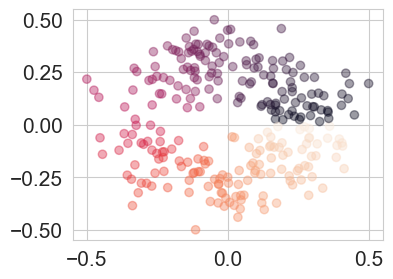

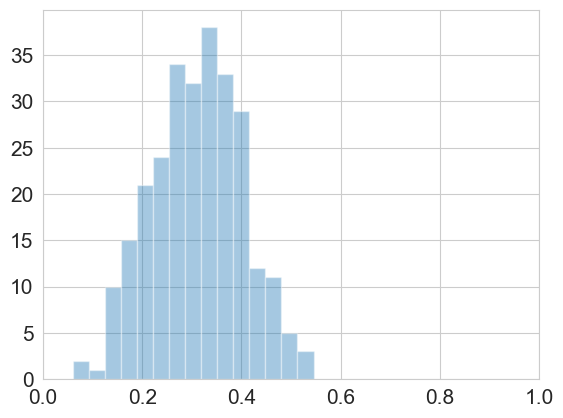

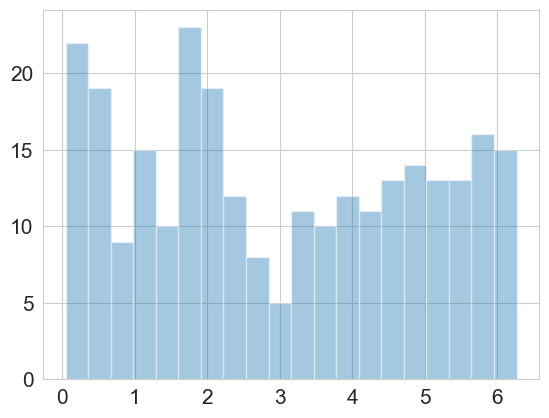

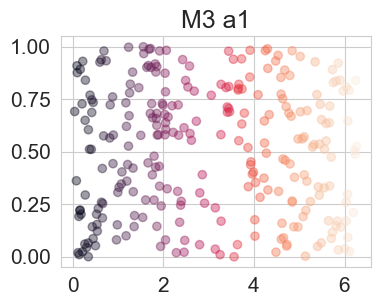

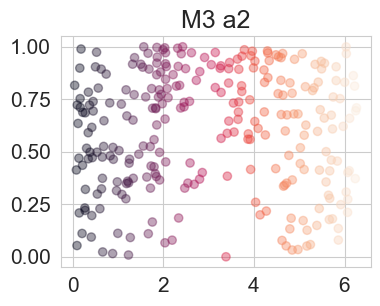

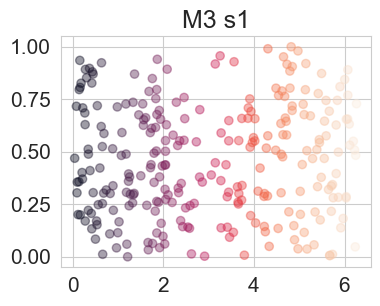

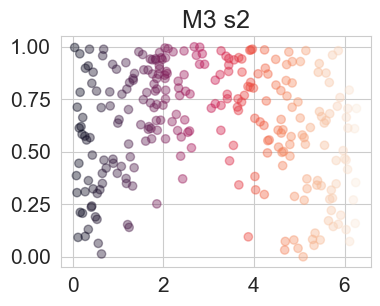

In [137]:
fig, ax = plt.subplots(1, 1, figsize=(4,3))
x = scaled_pars[:, 3]-0.5
y = scaled_pars[:, 4]-0.5

angles = (np.arctan2(y, x)+2*np.pi) %(2*np.pi)
radii = np.sqrt(x**2 + y**2)
ax.scatter(x, y, alpha=0.4, c=angles)
# plt.colorbar()
plt.show()

plt.hist(radii, bins=15, alpha=0.4)
plt.xlim((0, 1))
plt.show()
plt.hist(angles, bins=20, alpha=0.4)
# plt.xlim((-np.pi, np.pi))
plt.show()


for par in (13, 14, 23, 24):
# for par in (15, 16, 25, 26):
    
    plt.figure(figsize=(4,3))
    plt.scatter(angles, scaled_pars[:, par], alpha=0.4, c=angles)
    plt.title(par_names[par])
    # plt.xlim((-np.pi, np.pi))
# ax[1].scatter(scaled_pars[idx, 3], scaled_pars[idx, 4], alpha=0.4)

M3 a1 M3 a2


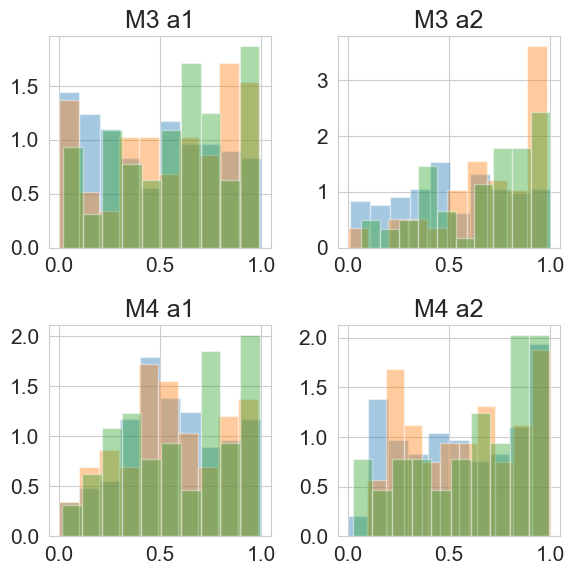

In [95]:
par = 13, 14, 15, 16  # 24, 26
# par = 23, 24, 25, 26  # 24, 26

print(par_names[par[0]], par_names[par[1]])

fig, ax = plt.subplots(2, 2, figsize=(6,6))
idx = scaled_pars[:, 3] >= 0.5
ax[0][0].hist(scaled_pars[idx, par[0]], alpha=0.4, density=True)
ax[0][1].hist(scaled_pars[idx, par[1]], alpha=0.4,density=True)
ax[1][0].hist(scaled_pars[idx, par[2]], alpha=0.4, density=True)
ax[1][1].hist(scaled_pars[idx, par[3]], alpha=0.4, density=True)


idx = (scaled_pars[:, 3] < 0.5) * (scaled_pars[:, 4] < 0.5)
ax[0][0].hist(scaled_pars[idx, par[0]], alpha=0.4, density=True)
ax[0][1].hist(scaled_pars[idx, par[1]], alpha=0.4, density=True)
ax[1][0].hist(scaled_pars[idx, par[2]], alpha=0.4, density=True)
ax[1][1].hist(scaled_pars[idx, par[3]], alpha=0.4, density=True)

idx = (scaled_pars[:, 3] < 0.5) * (scaled_pars[:, 4] > 0.5)
ax[0][0].hist(scaled_pars[idx, par[0]], alpha=0.4, density=True)
ax[0][1].hist(scaled_pars[idx, par[1]], alpha=0.4, density=True)
ax[1][0].hist(scaled_pars[idx, par[2]], alpha=0.4, density=True)
ax[1][1].hist(scaled_pars[idx, par[3]], alpha=0.4, density=True)

ax[0][0].set_title(par_names[par[0]])
ax[0][1].set_title(par_names[par[1]])
ax[1][0].set_title(par_names[par[2]])
ax[1][1].set_title(par_names[par[3]])

plt.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(7,3))
idx = scaled_pars[:, 3] >= 0.5
ax[0].scatter(scaled_pars[idx, 5], scaled_pars[idx, 6], alpha=0.4)
ax[1].scatter(scaled_pars[idx, 3], scaled_pars[idx, 4], alpha=0.4)

idx = (scaled_pars[:, 3] < 0.5) * (scaled_pars[:, 4] < 0.5)
ax[0].scatter(scaled_pars[idx, 5], scaled_pars[idx, 6], alpha=0.4)
ax[1].scatter(scaled_pars[idx, 3], scaled_pars[idx, 4], alpha=0.4)

idx = (scaled_pars[:, 3] < 0.5) * (scaled_pars[:, 4] > 0.5)
ax[0].scatter(scaled_pars[idx, 5], scaled_pars[idx, 6], alpha=0.4)
ax[1].scatter(scaled_pars[idx, 3], scaled_pars[idx, 4], alpha=0.4)
plt.tight_layout()
plt.show()

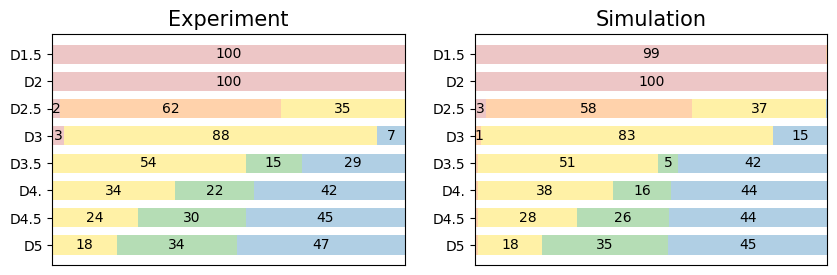

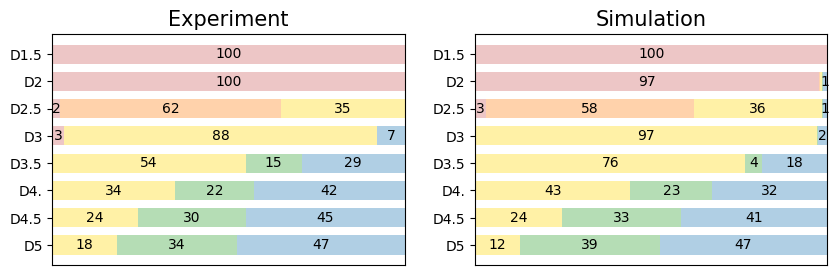

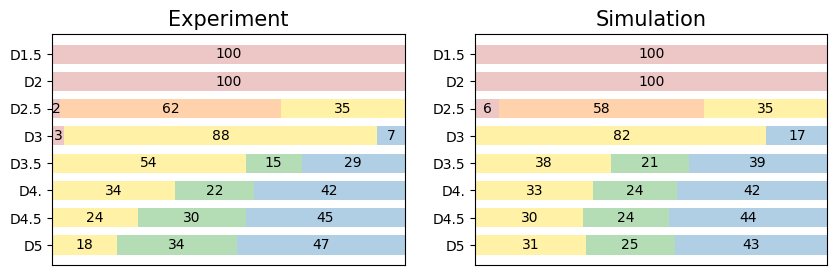

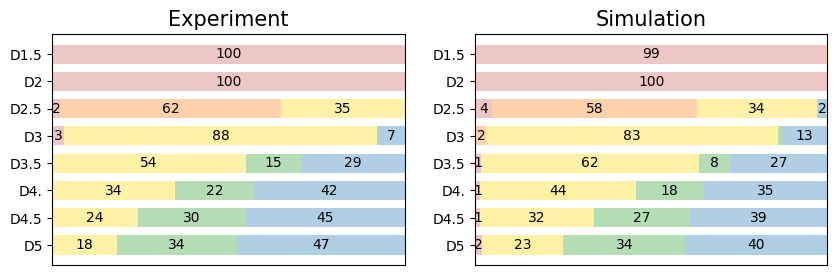

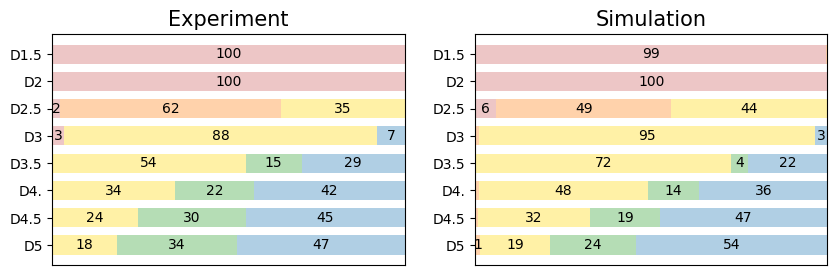

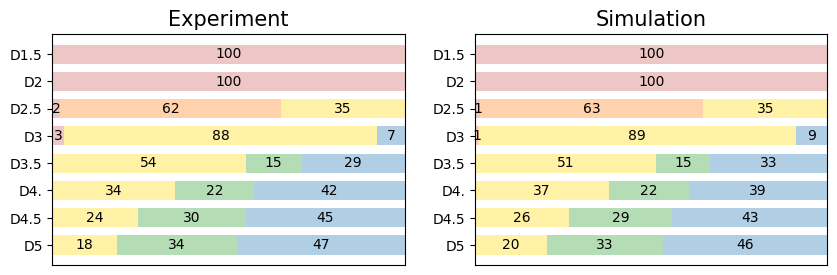

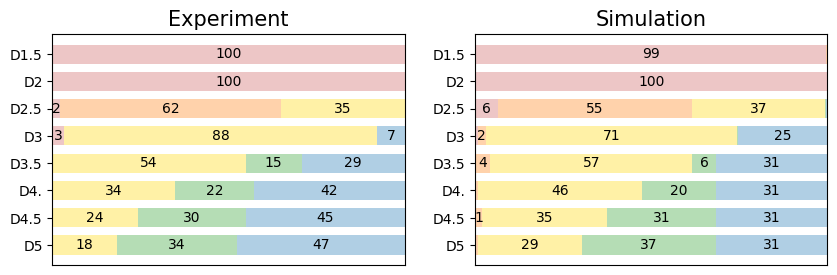

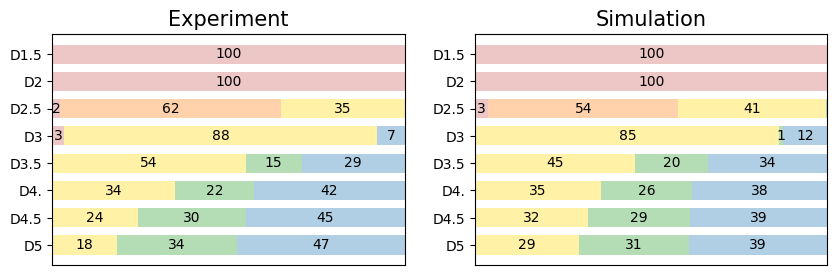

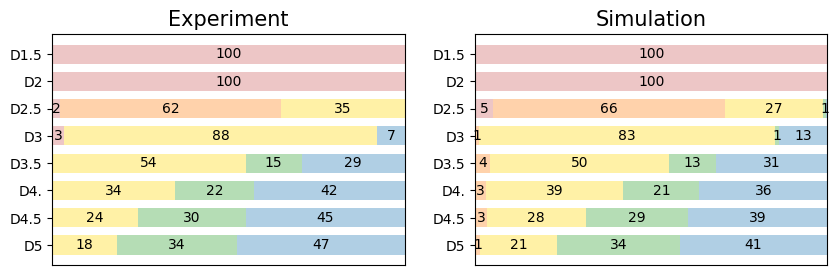

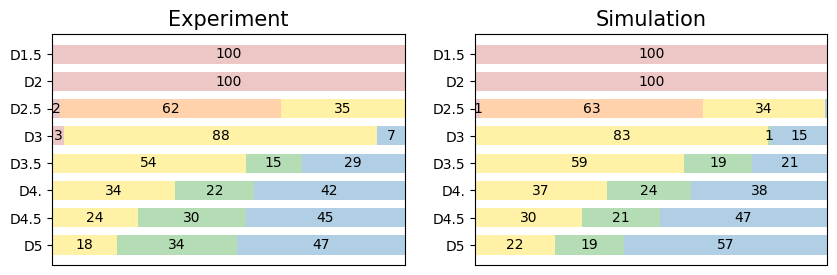

In [32]:
for i in range(10, 20):
    timecode = timecodes.iloc[i]
    figure_from_timecode(timecode, 'proportions_0')
    

In [101]:
# pca = PCA(n_components=None)
# pca.fit(scaled_pars)
# X = pca.transform(scaled_pars)
# 
# print(pca.explained_variance_ratio_)
# 
# plt.imshow(X, interpolation=None, cmap='RdBu_r', aspect=0.25)
# plt.title('PCA scores')
# plt.show()
# plt.imshow(pca.components_, interpolation=None, cmap='RdBu')
# plt.title('PCA components')
# plt.show()
# 
# for component in range(10):
#     plt.plot(pca.components_[component])
# plt.title('PCA components')
# plt.show()
# fig = plt.figure()
# ax = fig.add_subplot(111, projection="3d", elev=30, azim=-100)
# 
# ax.scatter(X[:, 0], X[:, 1], X[:, 2], c = all_fitness)
# plt.show()




2 clusters
-0.1515519146511393 0.02933464208934993
-0.15590936363902677 0.03187543459368908


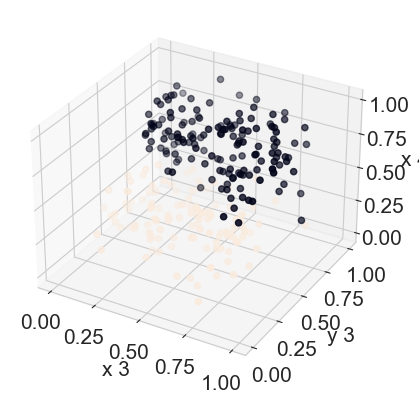

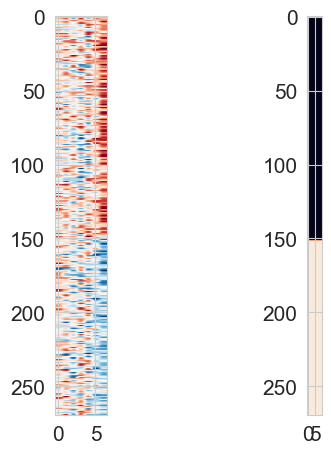

3 clusters
-0.14798135006609586 0.0296623678543681
-0.15405890215592777 0.0293440174447317
-0.15722306120901924 0.031454257846709785


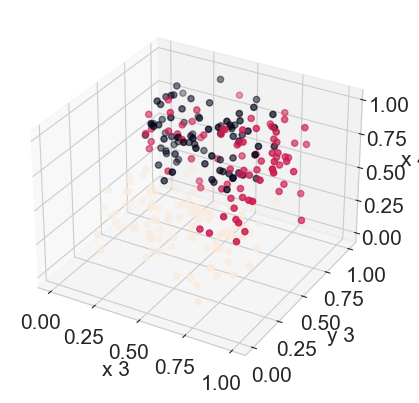

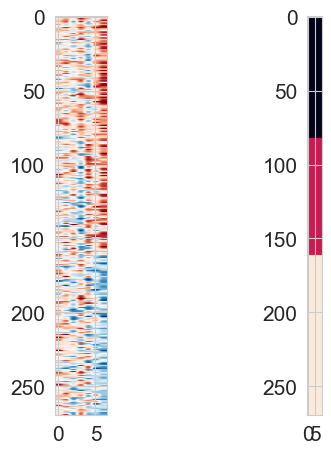

4 clusters
-0.1504474494219173 0.028786656157126982
-0.15151170796057484 0.0317251187315489
-0.15726443739583595 0.03317243540990445
-0.15527738735688104 0.028324992824283902


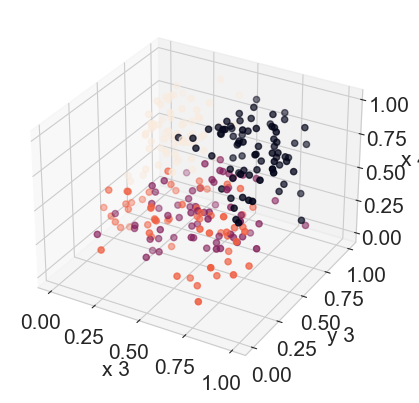

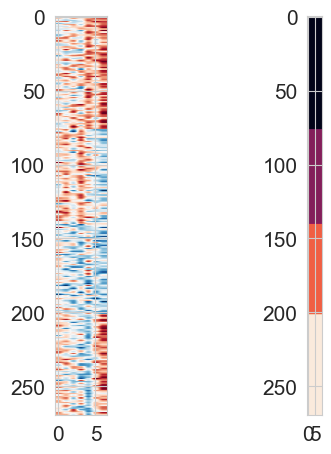

In [100]:
for n_clusters in np.arange(2,5):
    estimator = KMeans(n_clusters=n_clusters)
    X = scaled_pars[:, :7]
    estimator.fit(X)
    labels = estimator.labels_
    
    # print(np.labels)
    print(n_clusters, 'clusters')
    for label in np.unique(labels):
        label_fitness = all_fitness[labels == label]
        print(np.mean(label_fitness), np.std(label_fitness))
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d", azim=-60, elev=30)
    # ax.scatter(X[:, 1], X[:, 3], X[:, 9], c=labels.astype(float), edgecolor=None)
    ax.scatter(X[:, 4], X[:, 5], X[:, 6], c=labels.astype(float), edgecolor=None)
    
    ax.set_xlabel(par_names[1])
    ax.set_ylabel(par_names[3])
    ax.set_zlabel(par_names[9])
    
    ax.set_xlabel(par_names[3])
    ax.set_ylabel(par_names[4])
    ax.set_zlabel(par_names[5])
    
    plt.show()
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(X[np.argsort(labels), :], interpolation=None, cmap='RdBu_r', aspect=0.2)
    ax[1].imshow(np.tile( np.sort(labels), (10,1)).T)
    fig.tight_layout()
    plt.show()

In [99]:
# n_components = 2
# for perplexity in (5, 10, 30, 50):
#     tsne = TSNE(n_components=n_components,init="random",random_state=0,perplexity=perplexity,max_iter=1000)
#     X = scaled_pars.copy()
#     Y = tsne.fit_transform(X)
#     plt.scatter(Y[:, 0], Y[:, 1], c = all_fitness)
#     plt.show()

In [115]:
print(par_names[:7])
print(par_names[7:17])
print(par_names[17:])
idx = (np.r_[3:7, 11:17, 21:27]).astype('int')
print(par_names[11:17])


['x 0', 'x 1', 'y 1', 'x 3', 'y 3', 'x 4', 'y 4']
['M0 a1', 'M0 a2', 'M1 a1', 'M1 a2', 'M2 a1', 'M2 a2', 'M3 a1', 'M3 a2', 'M4 a1', 'M4 a2']
['M0 s1', 'M0 s2', 'M1 s1', 'M1 s2', 'M2 s1', 'M2 s2', 'M3 s1', 'M3 s2', 'M4 s1', 'M4 s2']
['M2 a1', 'M2 a2', 'M3 a1', 'M3 a2', 'M4 a1', 'M4 a2']


2 components
Score: 1.0871962049600092
0 fitness: -0.1536948287776093 0.03118109344276403
1 fitness: -0.15305075044184752 0.029435224386410837
Cluster 0


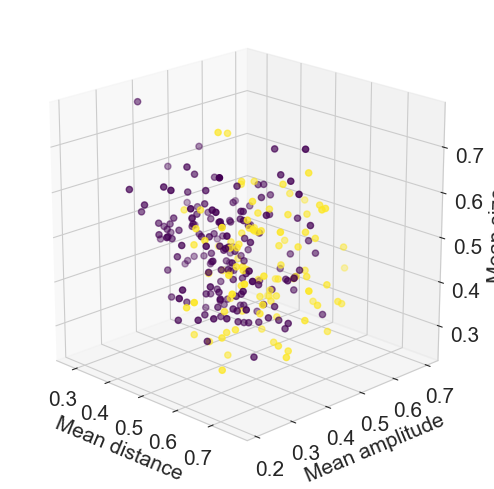

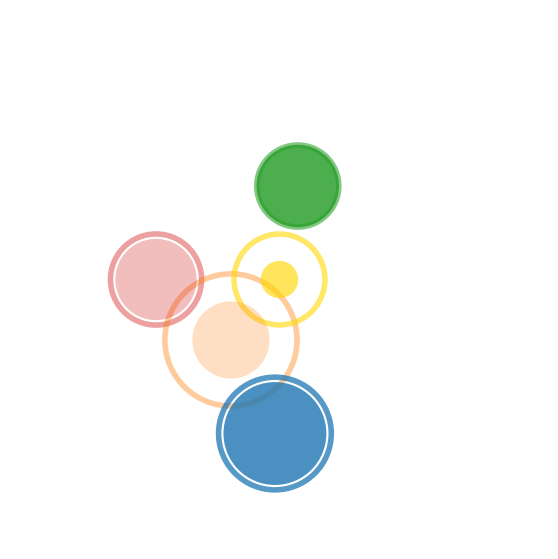

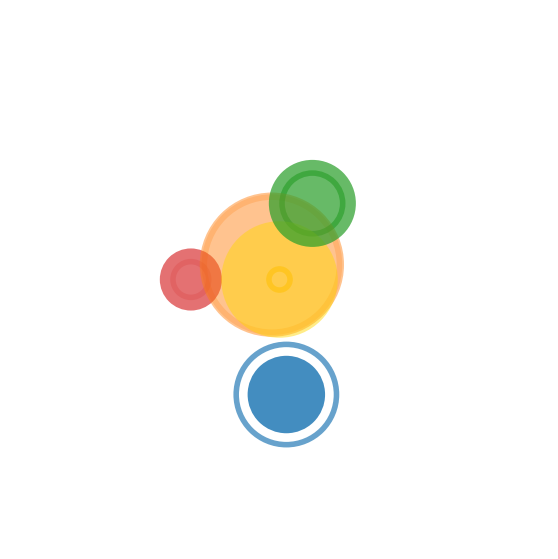

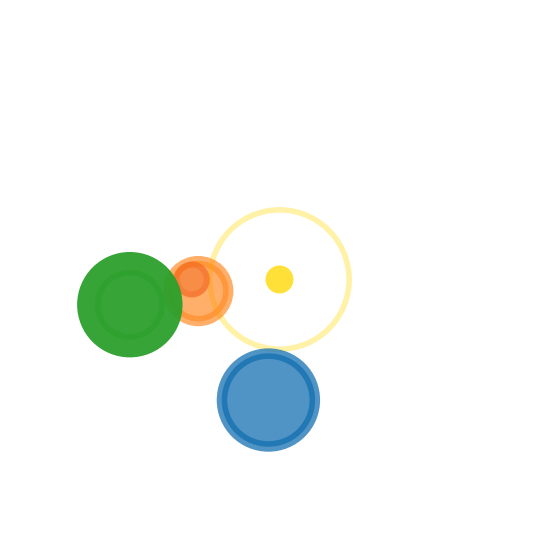

Cluster 1


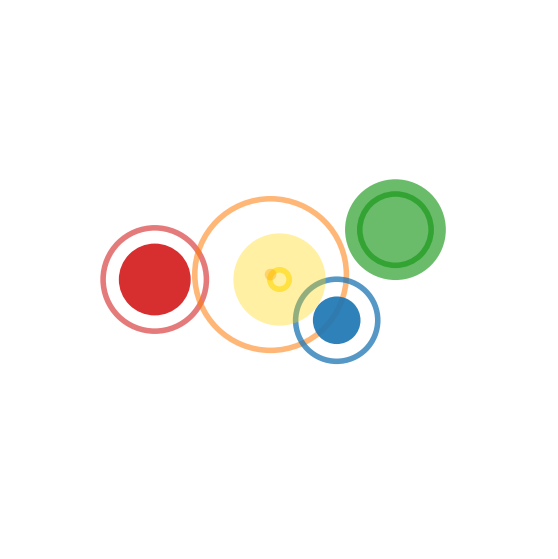

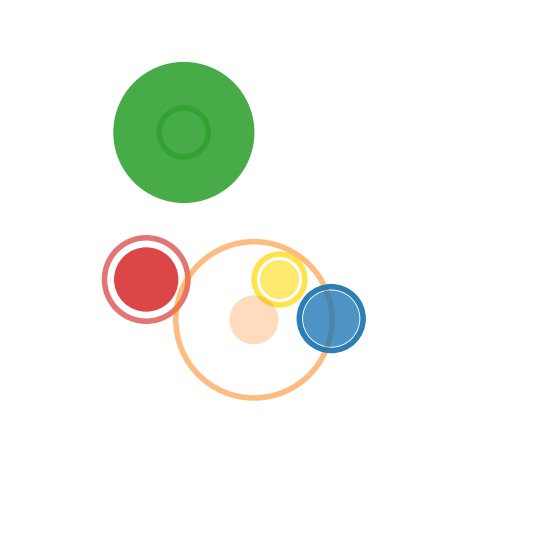

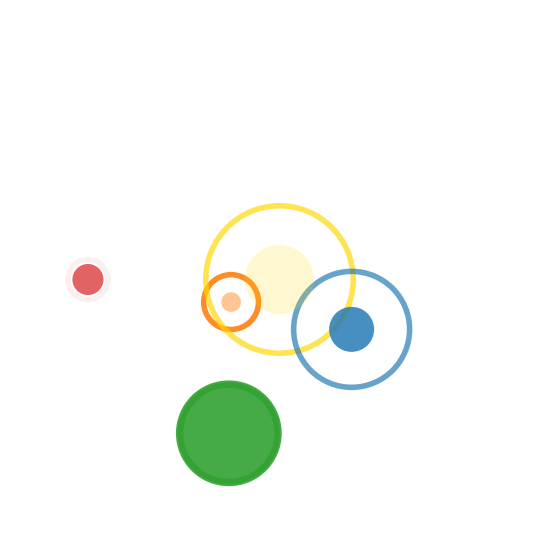

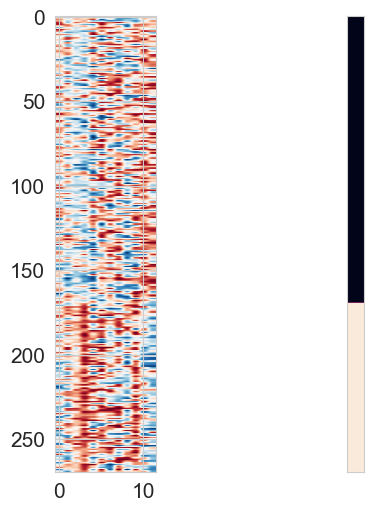

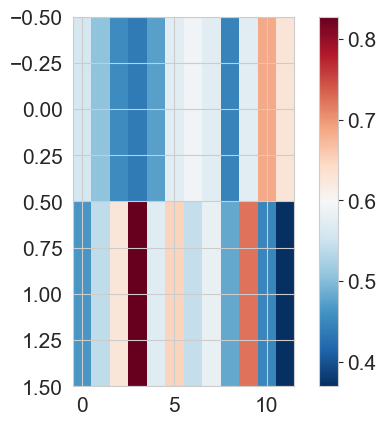

3 components
Score: 1.5949566136385889
0 fitness: -0.14802232758942602 0.03023816835679472
1 fitness: -0.1543036867386102 0.02981553507283797
2 fitness: -0.15575117755837267 0.030833100960266466
Cluster 0


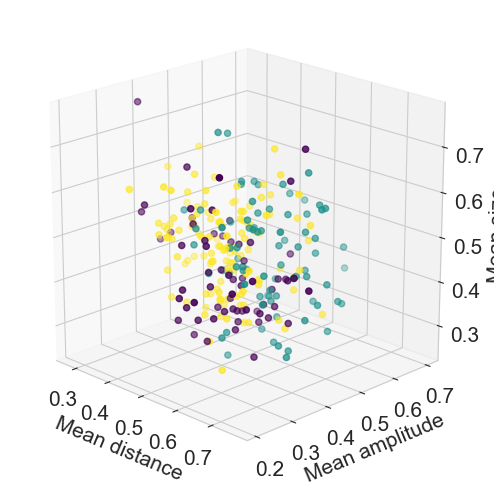

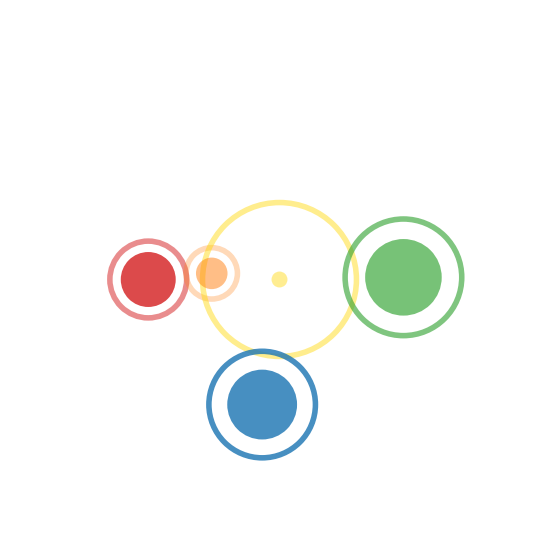

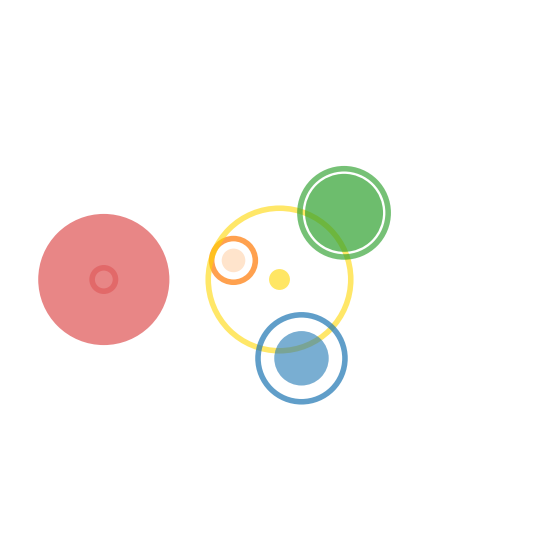

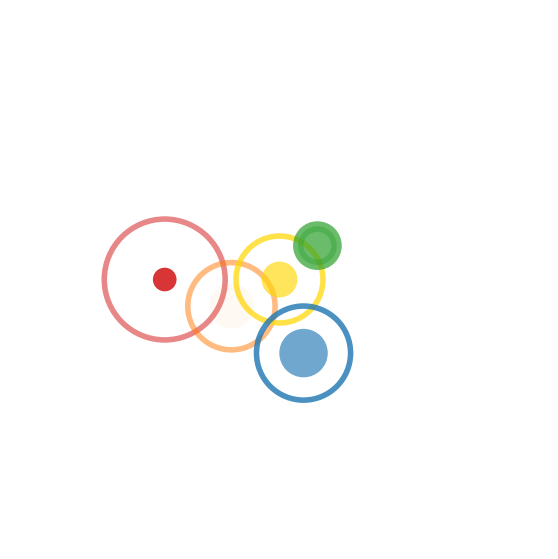

Cluster 1


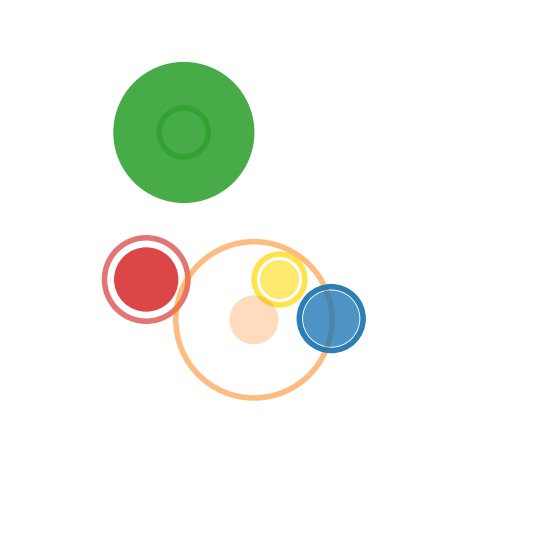

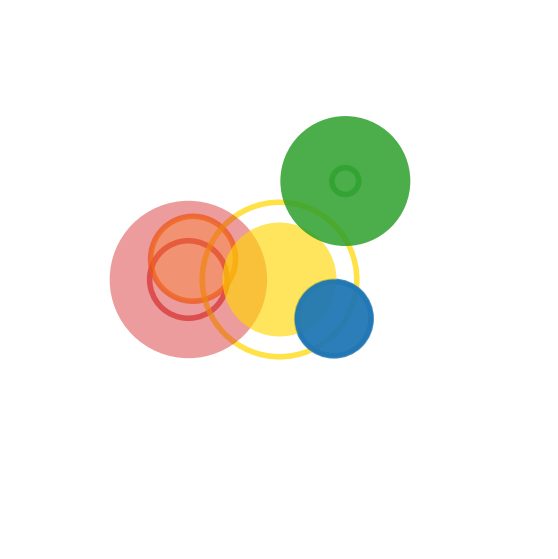

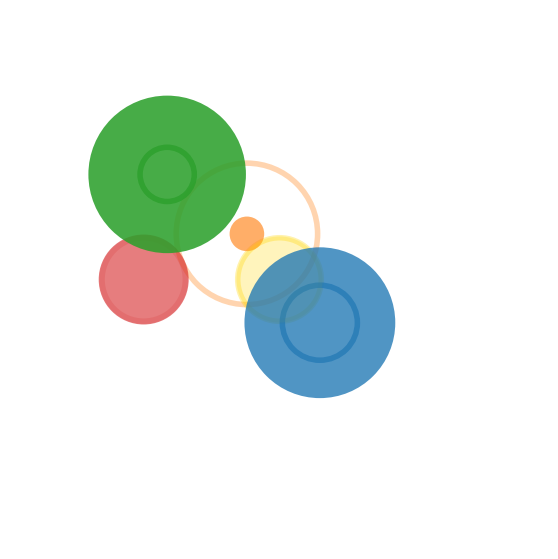

Cluster 2


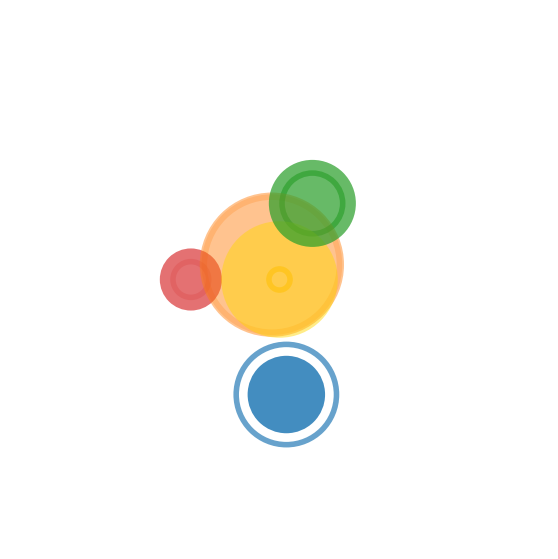

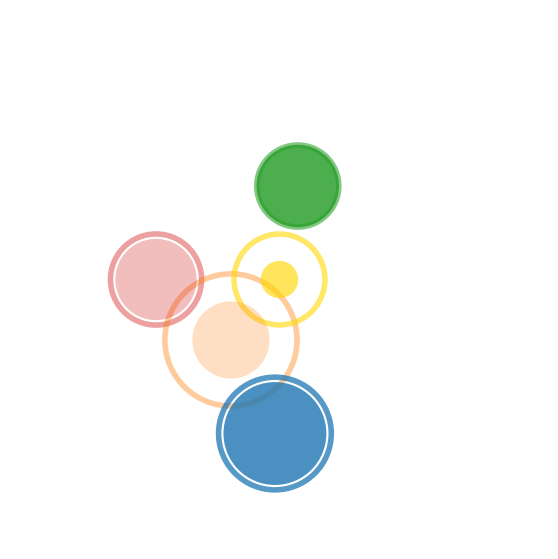

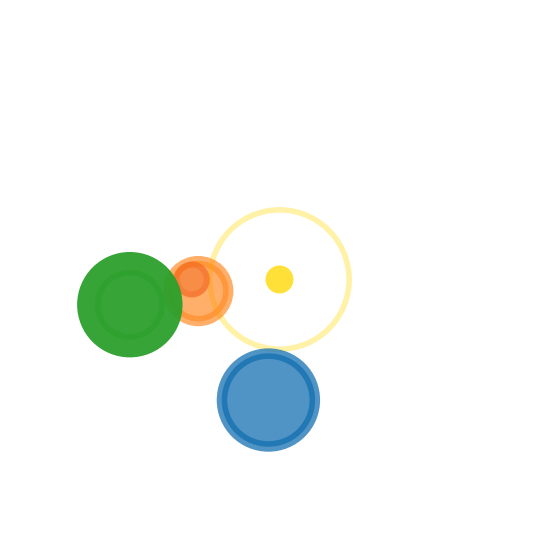

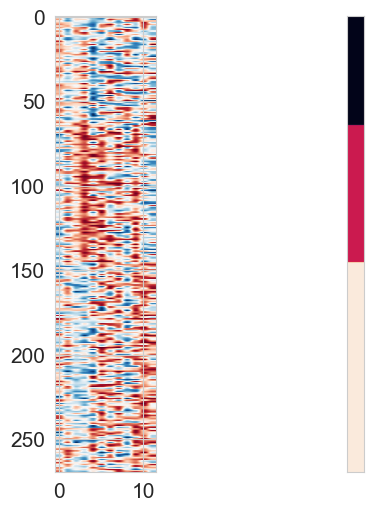

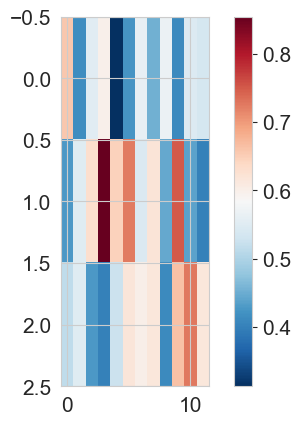

4 components
Score: 1.85792989934783
0 fitness: -0.1497442561209927 0.02946411108317113
1 fitness: -0.15391849857695766 0.032236698091178954
2 fitness: -0.15496362383124518 0.026983237770040698
3 fitness: -0.15440760031717327 0.03144212860888391
Cluster 0


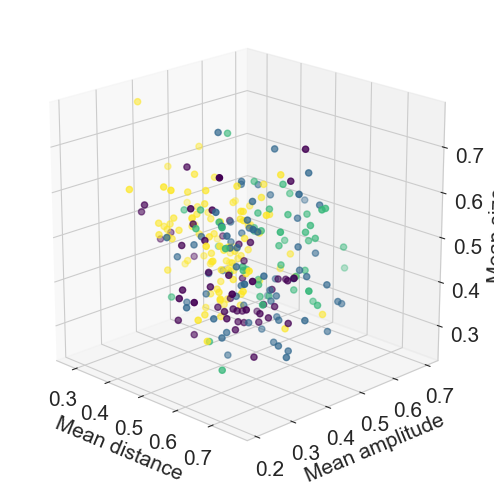

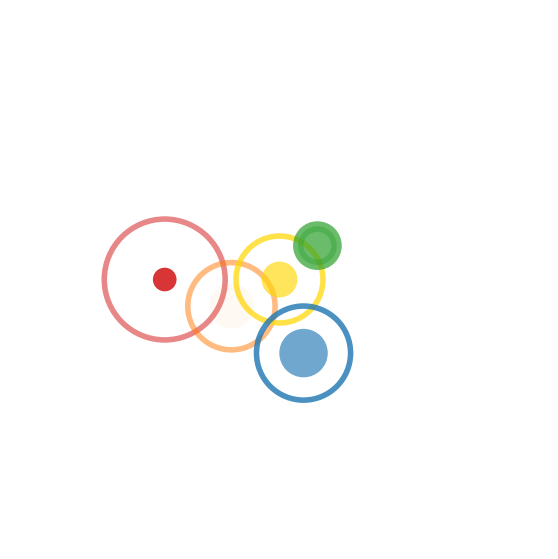

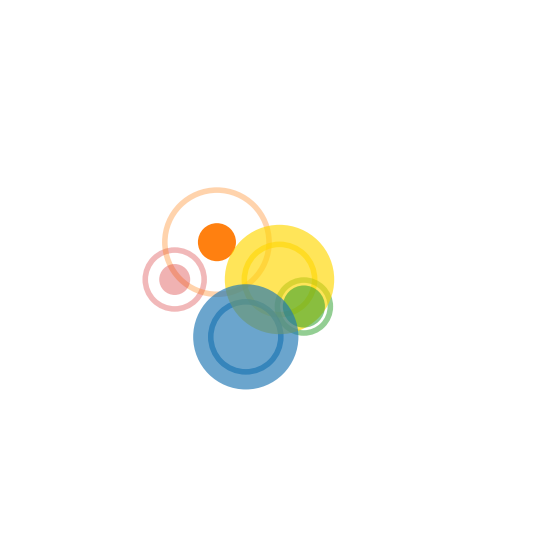

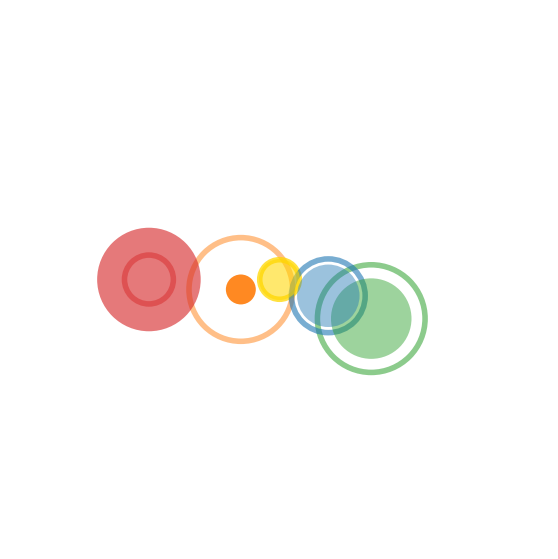

Cluster 1


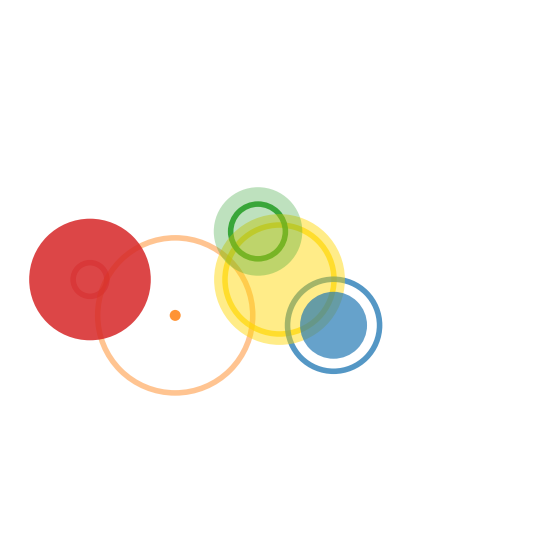

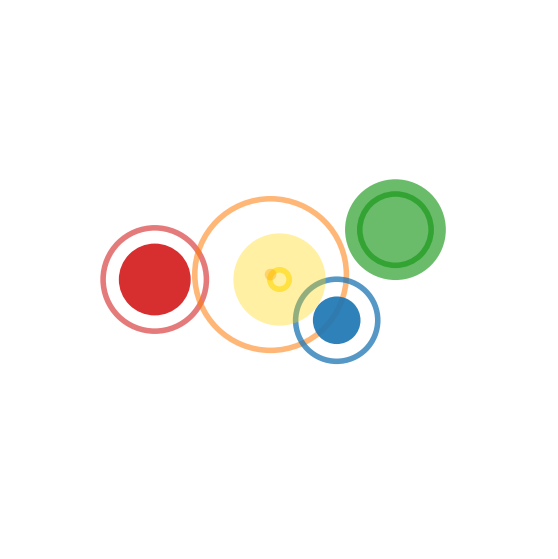

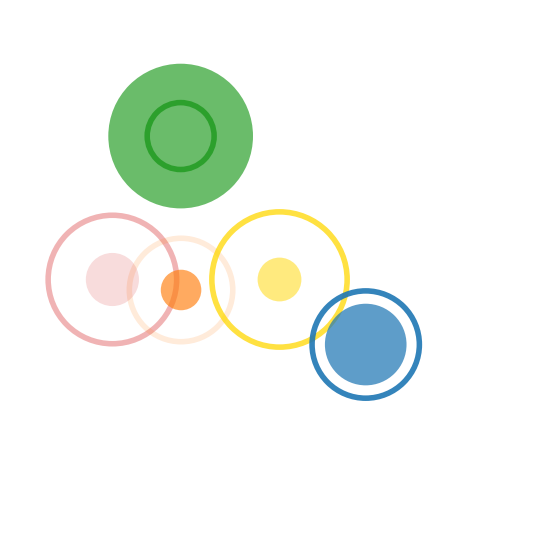

Cluster 2


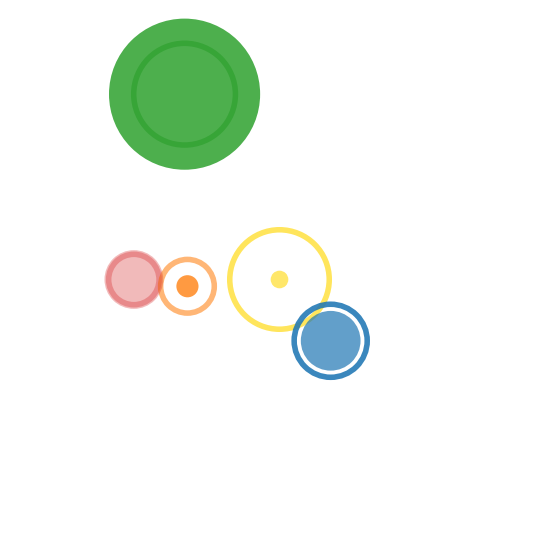

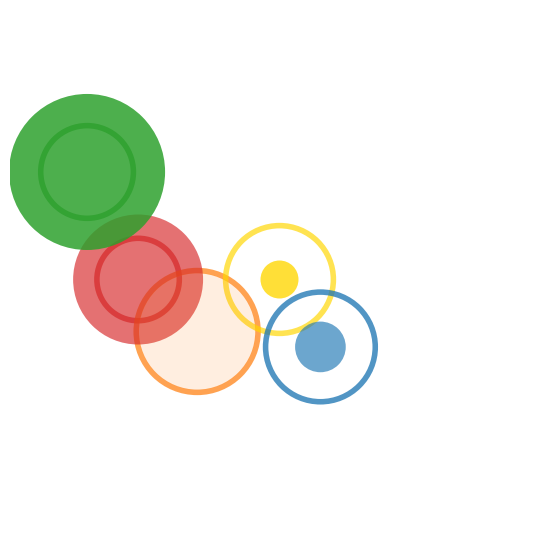

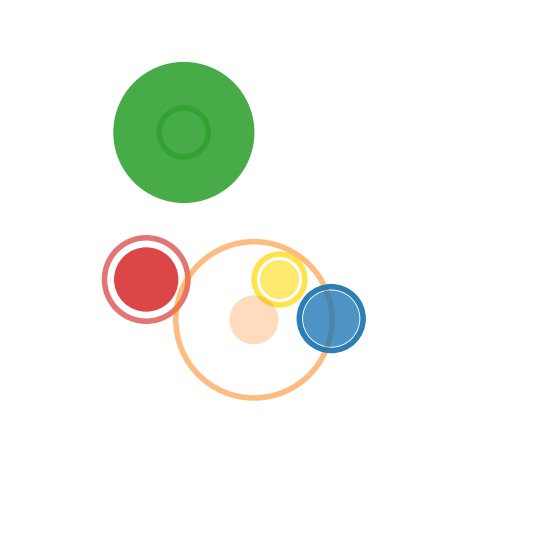

Cluster 3


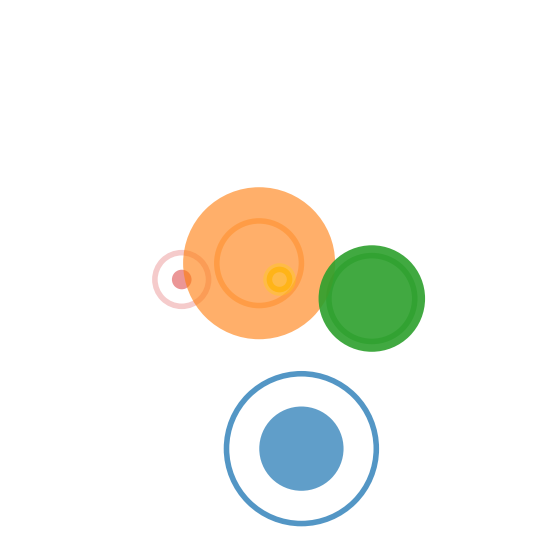

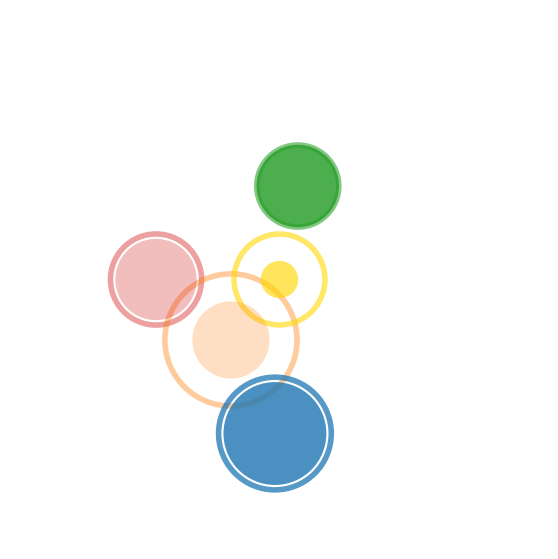

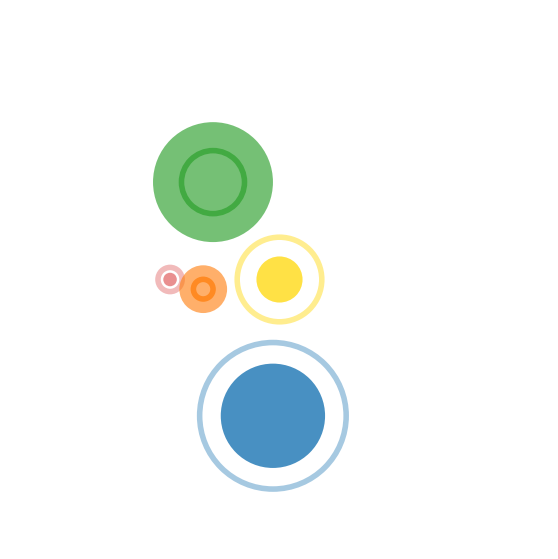

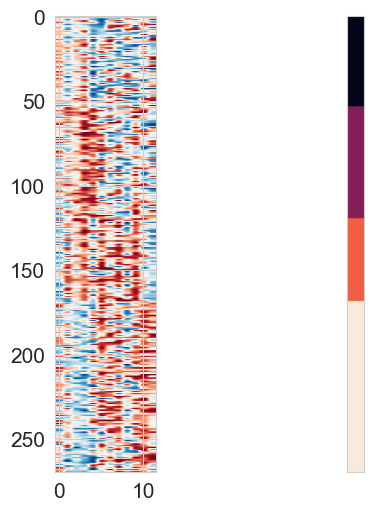

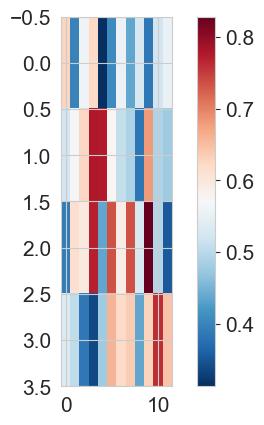

5 components
Score: 2.192577769882836
0 fitness: -0.14363355039994344 0.03291769066404887
1 fitness: -0.15453981376235615 0.0288616765139134
2 fitness: -0.1566488591321528 0.027916395401611737
3 fitness: -0.15676427148502375 0.03073297114885229
4 fitness: -0.15387862055049187 0.030151222352313177
Cluster 0


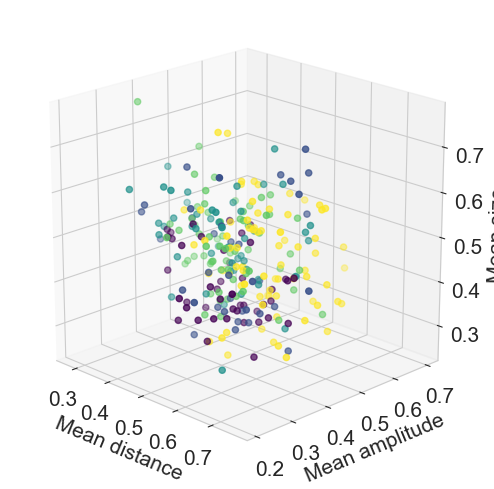

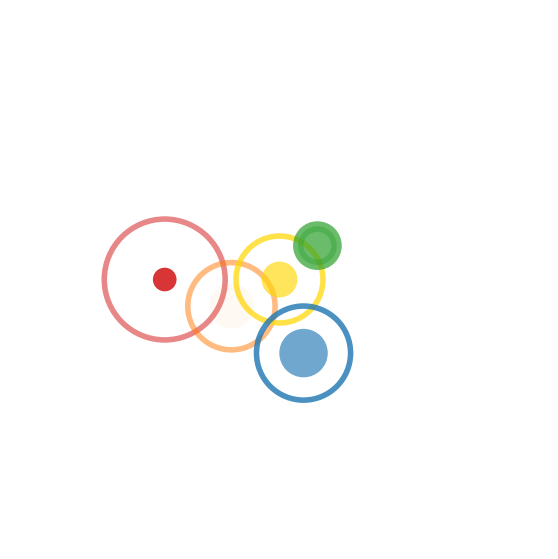

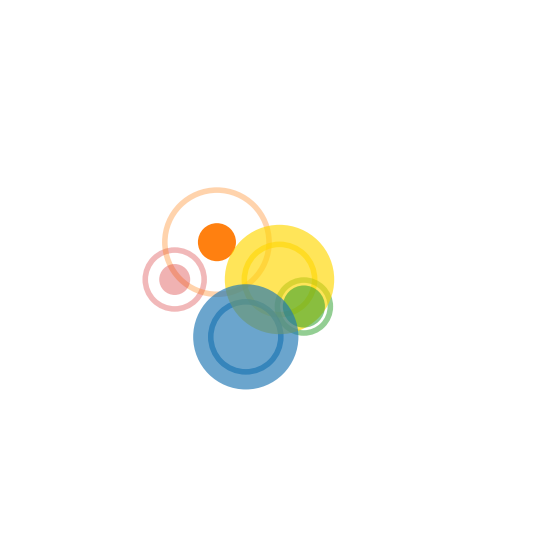

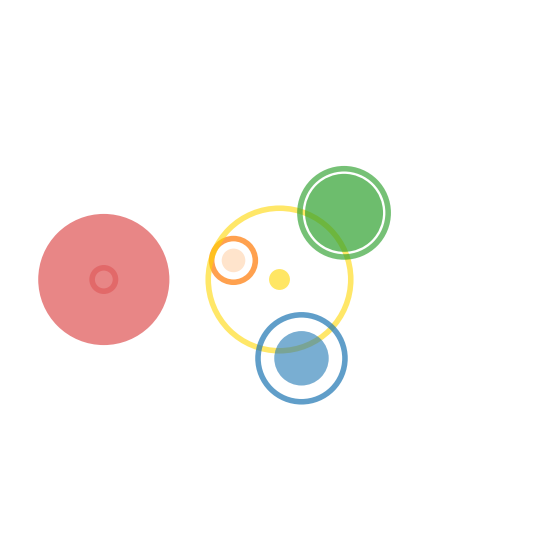

Cluster 1


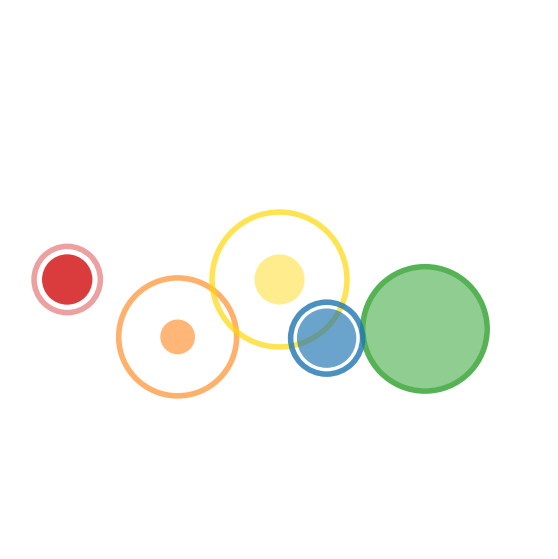

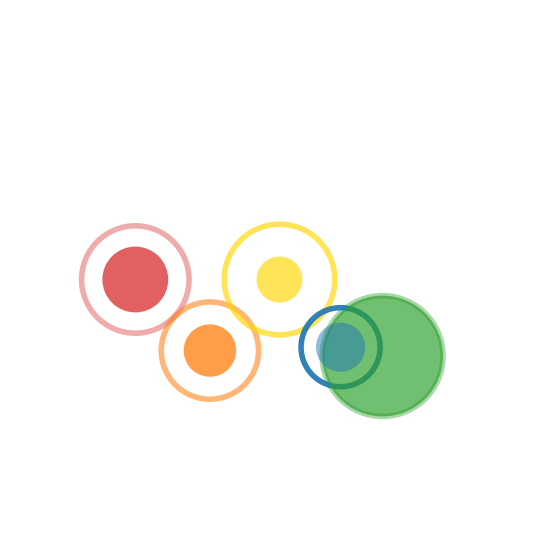

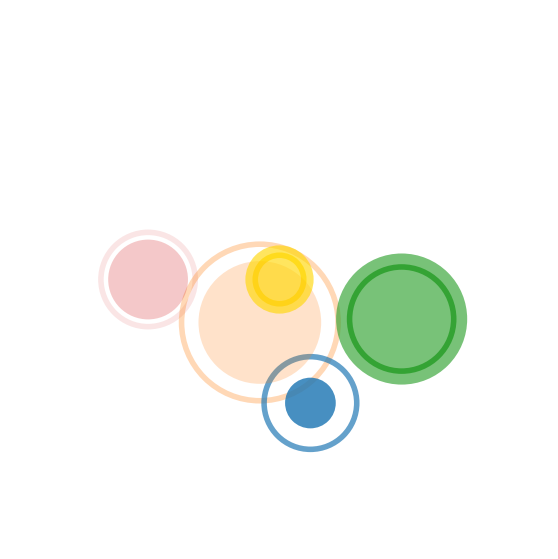

Cluster 2


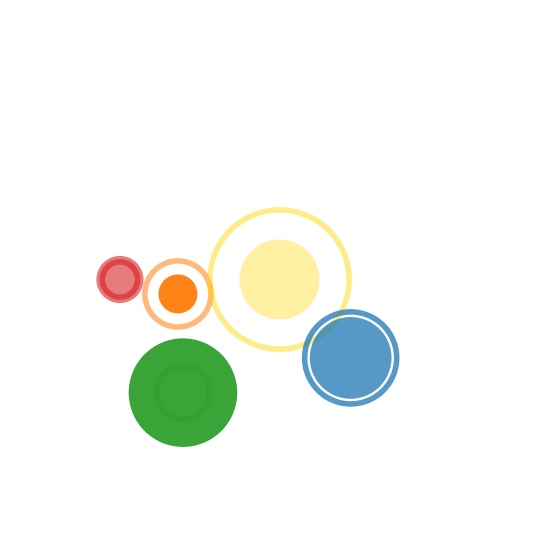

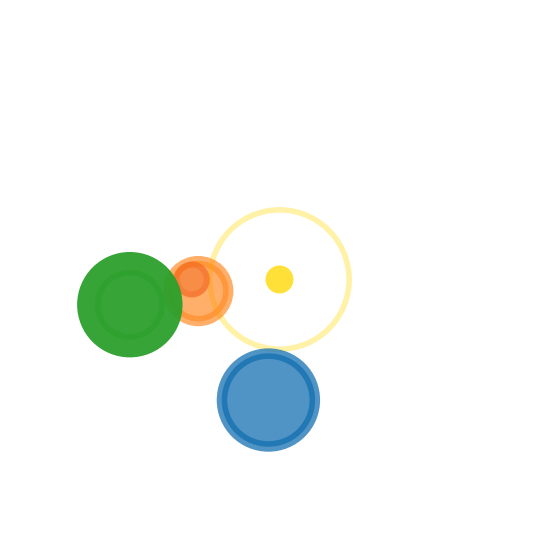

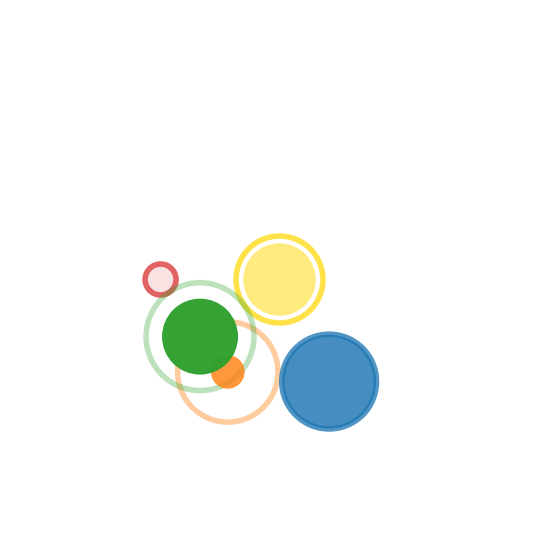

Cluster 3


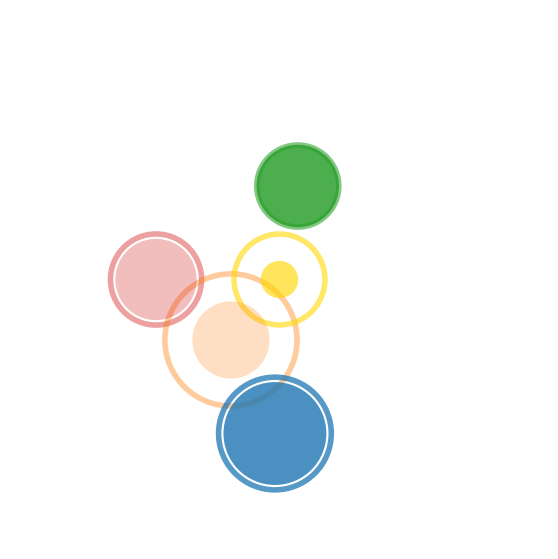

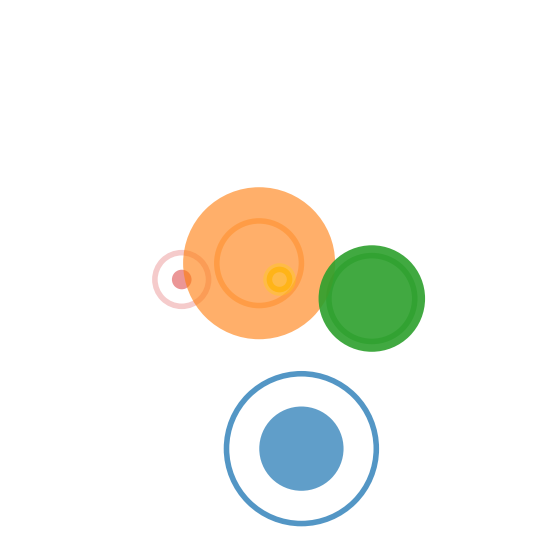

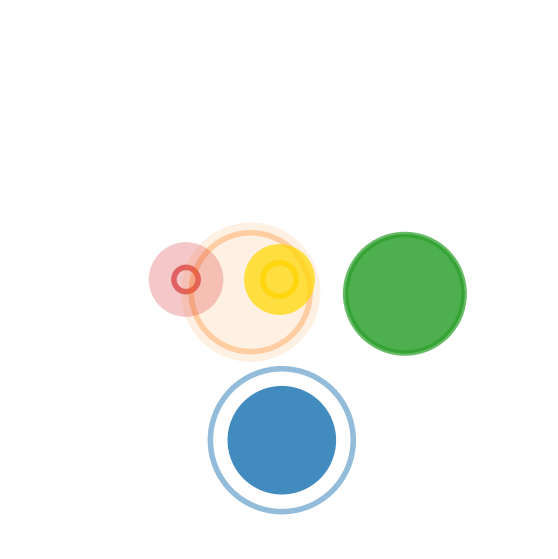

Cluster 4


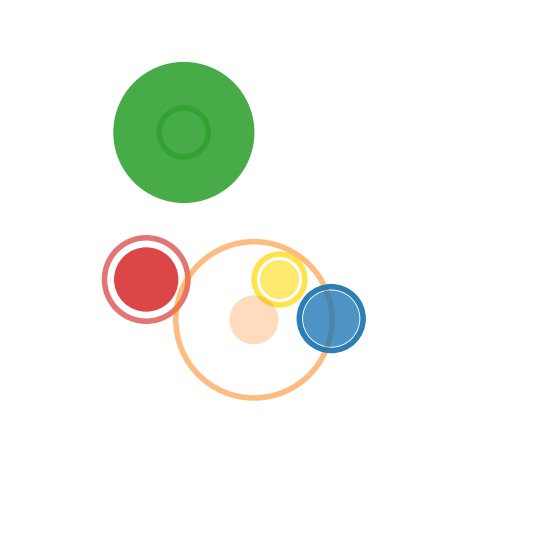

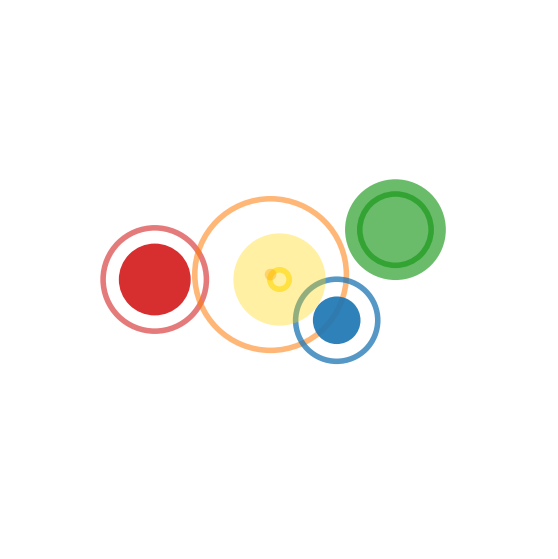

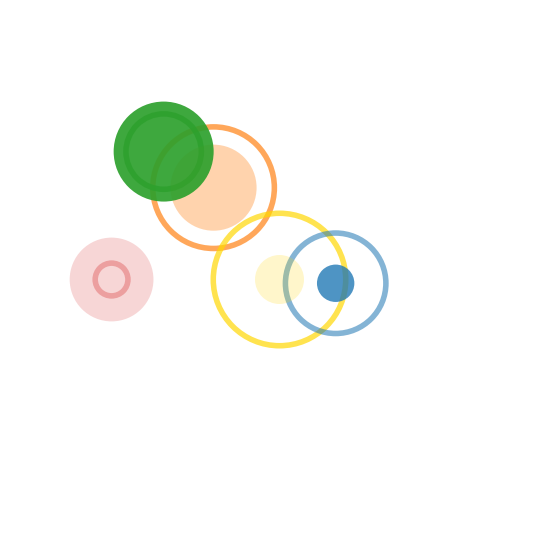

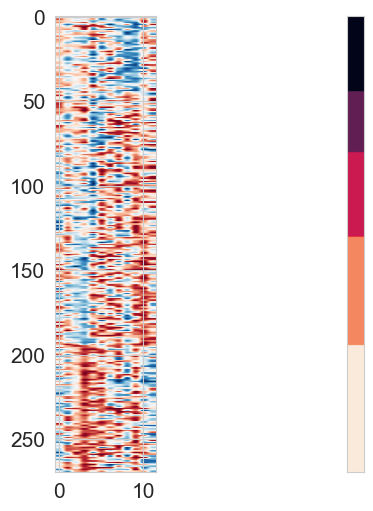

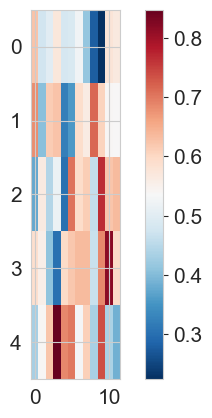

In [118]:
from sklearn.mixture import GaussianMixture
# X  = scaled_pars[:, 3:7, 13:17, 23:27]
X = scaled_pars[:, np.r_[3:7, 13:17, 23:27]]
for n_components in (2,3,4,5):
    print(n_components, 'components')
    gm = GaussianMixture(n_components=n_components, random_state=0, covariance_type='full').fit(X)

    labels = gm.fit_predict(X)
    
    print('Score:', gm.score(X))
    
    for label in np.unique(labels):
        label_fitness = all_fitness[labels == label]
        print(label, 'fitness:', np.mean(label_fitness), np.std(label_fitness))
        
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, projection="3d", azim=-45, elev=20)
    ax.set_aspect('equal')
    # ax.scatter(X[:, 1], X[:, 3], X[:, 9], c=labels.astype(float), edgecolor=None)
    # ax.set_xlabel(par_names[1])
    # ax.set_ylabel(par_names[3])
    # ax.set_zlabel(par_names[9])
    avg_dist = np.mean(scaled_pars[:, :7], axis=1)
    avg_a = np.mean(scaled_pars[:, 7:17], axis=1)
    avg_s = np.mean(scaled_pars[:, 17:], axis=1)
    # ax.scatter(X[:, 4], X[:, 5], X[:, 6], c=labels.astype(float), edgecolor='None', cmap='viridis')
    ax.scatter(avg_dist, avg_a, avg_s, c=labels.astype(float), edgecolor=None, cmap='viridis')
    ax.set_xlabel('Mean distance')
    ax.set_ylabel('Mean amplitude')
    ax.set_zlabel('Mean size')
    
    #  #  plot the landscapes closest to the center and the cluster mean _______________
    # Xc = np.zeros((n_components, 3))
    for k in range(n_components):
        
        Xk = X[labels==k, :]
        all_pars_k = all_pars[labels==k, :]
        timecodes_k = timecodes[labels==k]
        ind = np.argmin(np.linalg.norm(Xk - gm.means_[k], 1, axis=1))
        timecode = timecodes_k.iloc[ind]
        
        print('Cluster', k)
        
        idx = np.argpartition(np.linalg.norm(Xk - gm.means_[k], 1, axis=1), 3)
        circle_plot(all_pars_k[idx[0]])
        circle_plot(all_pars_k[idx[1]])
        circle_plot(all_pars_k[idx[3]])
        
        
        # figure_from_timecode(timecode, 'landscape_1')
        # figure_from_timecode(timecode, 'landscape_2')
        

        # Xc[k] = Xk[ind, 1], Xk[ind, 3], Xk[ind, 9]
        # landscape=landscape_from_timecode(timecode, data_dir, 299, landscape_pars)
        # print(landscape)
    # ax.scatter(Xc[:, 0], Xc[:, 1], Xc[:, 2], c=range(n_components), marker = 'o', s=100, alpha=1)
    # means = gm.means_
    # ax.scatter(means[:, 1], means[:, 3], means[:, 9], c=range(n_components), marker = '*', s=150, alpha=1)
    
    # plt.legend()
    # plt.tight_layout()
    plt.show()


#  uncomment _________________
    fig, ax = plt.subplots(1,2, figsize=(5,5), width_ratios=(9,1), constrained_layout=True)
    ax[0].imshow(X[np.argsort(labels), :], interpolation=None, cmap='RdBu_r', aspect=0.2)
    ax[1].imshow(np.tile( np.sort(labels), (10,1)).T)
    ax[1].set_yticks([])
    ax[1].set_xticks([])
    plt.show()
    
    plt.imshow(gm.means_, cmap='RdBu_r', aspect=10)
    plt.colorbar()
    plt.show()
# ____________________
    

    # scores = gm.score_samples(X[np.argsort(labels), :])
    # plt.plot(scores)
    # plt.show()
    # for k in range(n_components):
    #     dist = np.linalg.norm(X[np.argsort(labels)] - gm.means_[k], 2, axis=1)   
    #     plt.plot(dist)
    #     plt.ylim((0,10))
    # plt.show()
    # plt.legend()

    # print(np.round(gm.means_, 2))




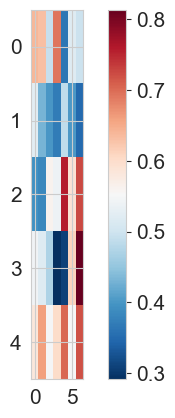

In [104]:
plt.imshow(gm.means_, cmap='RdBu_r', aspect=10)
plt.colorbar()

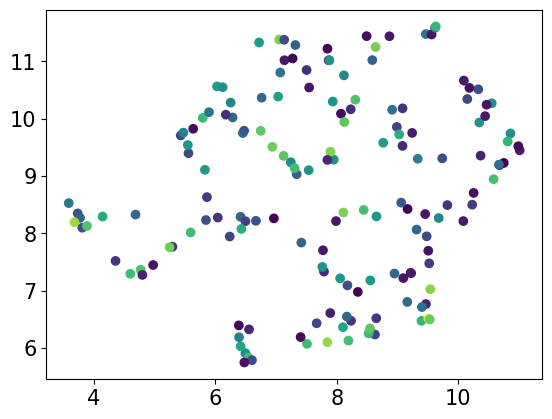

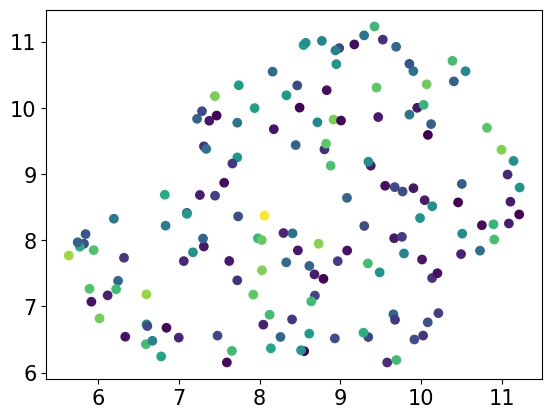

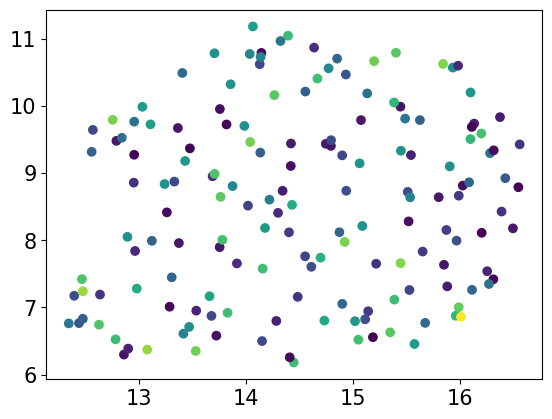

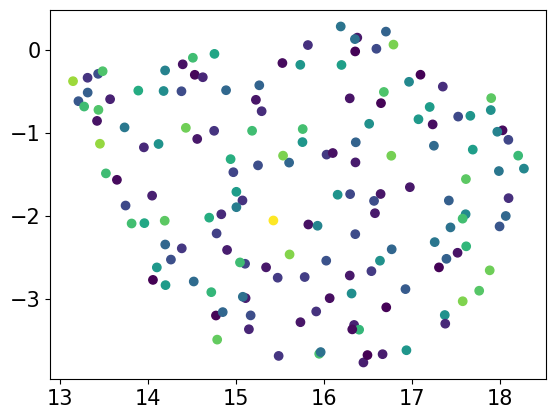

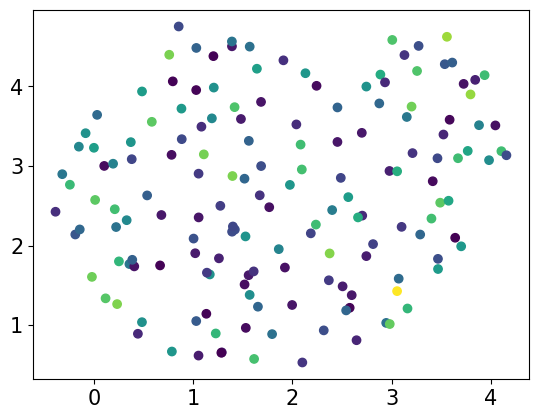

In [152]:
import umap


for n_neighbors in (5, 10, 20, 30, 50):
    
    reducer = umap.UMAP(n_neighbors=n_neighbors, metric='euclidean')
    
    embedding = reducer.fit_transform(all_pars)
    
    plt.scatter(embedding[:, 0], embedding[:, 1], c = all_fitness)
    plt.show()

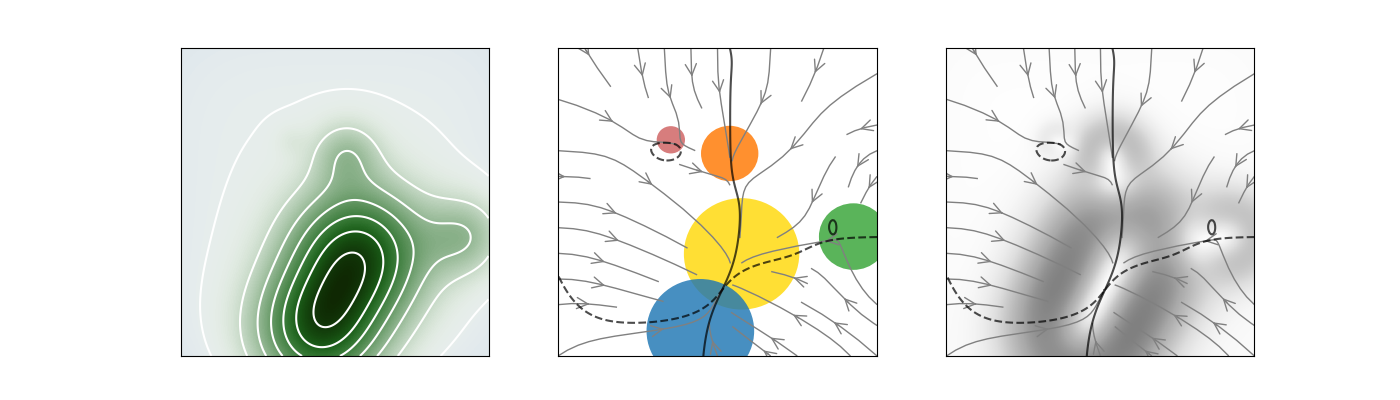

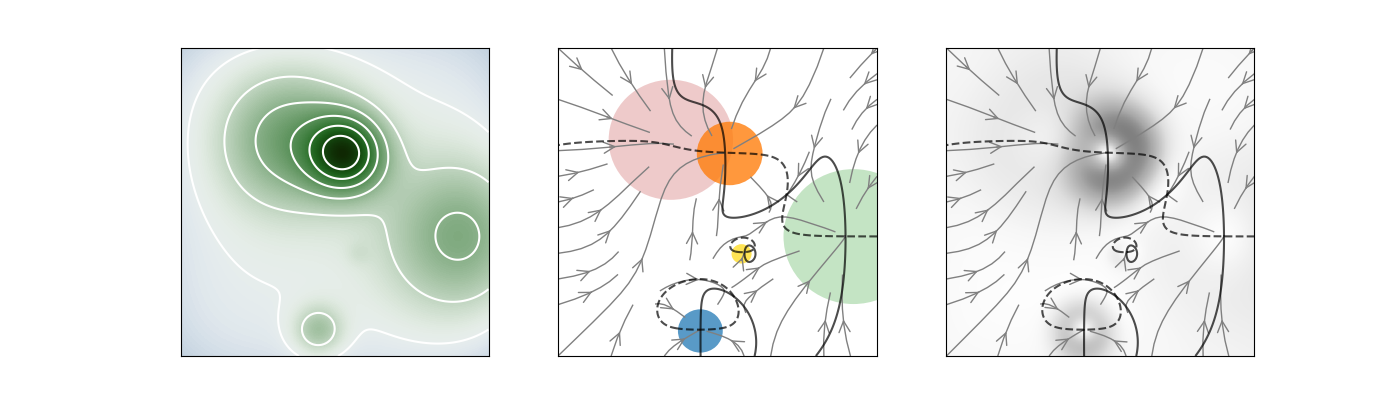

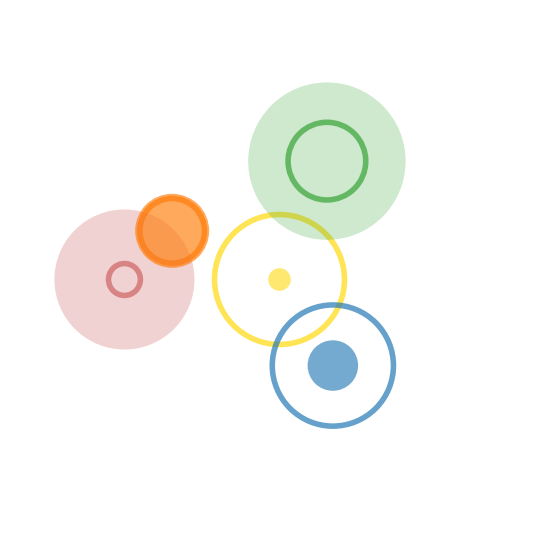

In [236]:
figure_from_timecode(timecodes.iloc[17], 'landscape_1', data_dirs[0])
figure_from_timecode(timecodes.iloc[17], 'landscape_2', data_dirs[0])
circle_plot(all_pars[17])